In [1]:
%load_ext autoreload
%autoreload 2
import sys

# sys.path.insert(0, '/gws/nopw/j04/ceh_generic/matbro/ecocrop')
from ecocrop_utils import *
from precscore import *
import glob
import pandas as pd
import xarray as xr
import numpy as np
import dask as da
import cftime as cf
import datetime as dt
import rasterio as rio

# import rioxarray
import geopandas as gpd
import rasterio.plot as rplt

# from numba import njit, prange
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess as subp
import os

Aim is to use the EcoCrop database to produce maps of crop suitability in the UK based on UKCP18 data. One map per year(?) for each species. Regarding the ensemble nature of the driving data we will produce these using ensemble member 01 as this is determined to be the ‘central’ of the ensembles in terms of temperature and precipitation. If time permits, the others could be used as an estimate of uncertainty.

The EcoCrop database contains parameters that determine the range of conditions in which the crop can grow. The ones we will focus on here are temperature, precipitation, killing temperature, habitat zone, latitude and altitude.

The first step is to determine which crops will clearly be unsuitable in the future, regardless of unchecked anphropogenic climate change. We can do this using the habitat zone and latitude. Plants solely able to grow in a tropical environment, or with latitudes that only encompass the tropics, can be removed straight away.

Then we focus on precipitation and temperature. The way to approach temperature is to calculate a forward-rolling total of the number of days within the temperature range, varying the window size up from GMIN until we obtain at least GMIN optimal days. This is the shortest time in which the crop can be grown (GTIME). Then check if the temperature went below the killing temperature within the window, in which case the crop would have failed. So we do a forward-rolling total (so the next x days) of killing temperature days and optimal temperature days, and where a certain day's optimal temperature total exceeds GMIN and the killing-days total is 0, the crop is a success if planted on that day. Then we check that the precip total in the window is within the allowed range for the crop. 

So, for each crop:
- Calculate forward-rolling total of days between TMAXO and TMINO (GTIME), initially with a window size of GMIN, incrementing up to GMAX. Where this is <GMIN, suitability is 0.
- Calculate forward-rolling total of days below KTMP with the same window size: KTMPDAYS for locations where suitability != 0
- KTMPDAYS=0 means successful crop based on T alone, otherwise crop fails, suitability back to 0.
- Calculate forward-total of precip (P) over same window, where suitability != 0, check within range of crop (PMIN and PMAX).
- Calculate suitability score (see below)
- What we have at this stage is a suitability score for a crop for each start day of planting, only considering the shortest possible growing time.
- Repeat for all larger window sizes up to GMAX
- Maximum suitability score from these for each day is final

Then we need to convert this into a suitability score. For temperature this can be based on how soon after GMIN days the crop is ready, for precip this can be based on where within the suitable precip range the actual precip falls. Something like:
$$\left(1-\frac{GTIME - GMIN}{GMAX-GMIN}\right)*100$$
where 
- GMIN is the minimum number of 'growing days' the crop needs 
- GMAX is the maximum
- GTIME is the actual number of 'growing days'
- 'growing days' is defined here as days when the temperature is between TMINO and TMAXO

and
$$\frac{100}{PMINO-PMIN}\left(P-PMIN\right), \:\text{for}\: PMIN<=P<PMINO$$

$$100, \:\text{for}\: PMINO<=P<=PMAXO$$

$$\frac{100}{PMAX-PMAXO}\left(PMAX-P\right), \:\text{for}\: PMAXO<P<=PMAX$$
where
- PMIN is the minimum precip the crop needs
- PMAX is the maximum precip the crop can take
- PMINO is the minimum optimum amount of precip the crop should get
- PMAXO is the maximum optimum amount of precip the crop should get

The precip calc bit looks something like:

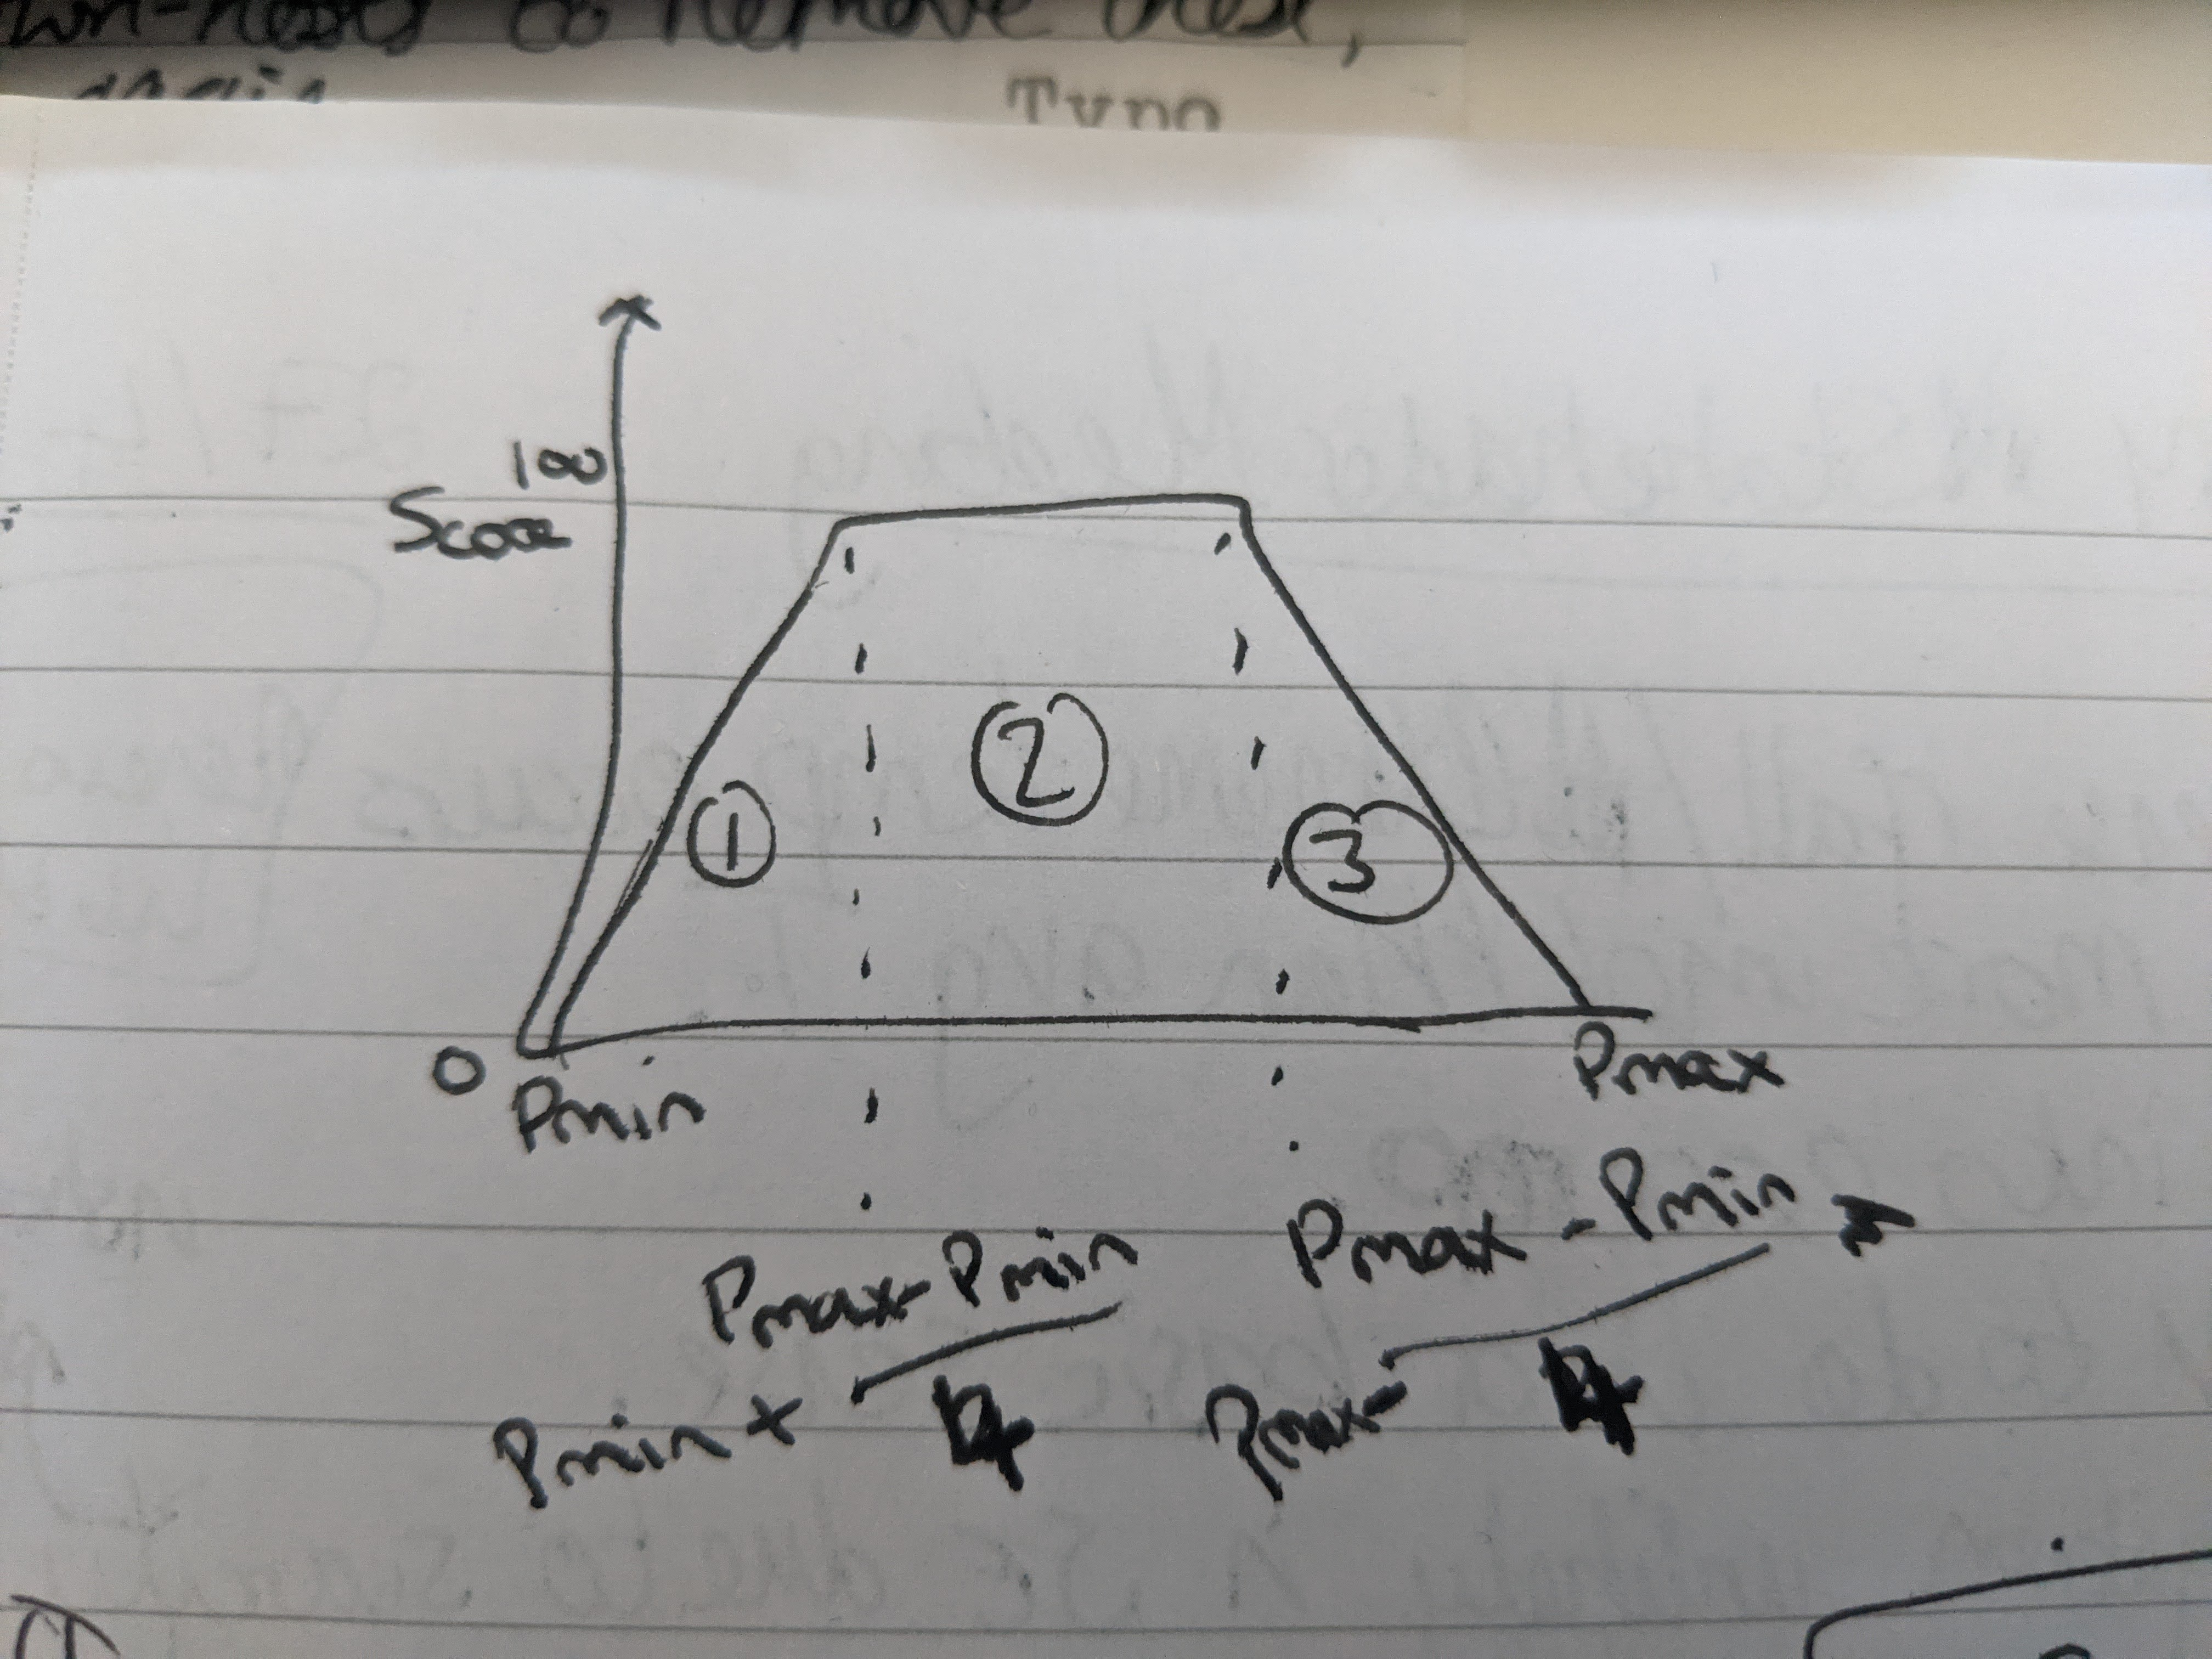

In [9]:
display.Image("Pgraph.jpg")

Could combine both into a bivariate distribution somehow, or just take the average/sum of them.

What makes this tricky is that we have several hundred crops (600). For each of these we need to calculate a suitability score for each day of the 100-year dataset. To do this, we need to calculate a suitability score for all the possible growing-lengths (GTIMEs) between GMIN and GMAX (by summing up the number of days temperature is between a given range). And we have to do this for each grid point in a 1km grid.
This is **A LOT** of number crunching. It is approximately 600x100x365x150x1000x650=2.1E15 (2000 quadrillion) calculations.

We can make some simplifications, like only calculating it for 2020 onwards (rather than 1980), and only calculating for every 10 GTIMEs (i.e. if GMIN was 100 and GMAX is 200, we would calculate for GTIMEs of 100,110,120...200 instead of 100,101,102...200). We could simplify further by not doing the calculation for every day of the dataset, but this makes the coding more complicated as we can no longer use a rolling sum method.
Ultimately, there is no getting around the fact that this is a big calculation. Numpy's vector calculations, and dask's parallelisation help speed things up a bit, and this is the approach I settled with. It is the 'Calculation v2' section below.  

### Initial data processing

#### EcoCrop

In [222]:
ecocropall = pd.read_csv(
    "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB.csv", engine="python"
)

In [223]:
ecocropall = ecocropall.drop(
    [
        "AUTH",
        "FAMNAME",
        "SYNO",
        "PHOPMN",
        "PHOPMX",
        "PHMIN",
        "PHMAX",
        "LIOPMN",
        "LIOPMX",
        "LIMN",
        "LIMX",
        "DEP",
        "DEPR",
        "TEXTR",
        "FER",
        "FERR",
        "TOX",
        "TOXR",
        "SAL",
        "SALR",
        "DRA",
        "DRAR",
        "ABITOL",
        "ABISUS",
        "INTRI",
        "PROSY",
    ],
    axis=1,
)

In [224]:
ecocropall

EcoPortCode             ScientificName  \
0             289     Abelmoschus esculentus   
1             290        Abelmoschus manihot   
2             291      Abelmoschus moschatus   
3             295      Acacia auriculiformis   
4             297          Acacia farnesiana   
...           ...                        ...   
2563       400000  Chamaecrista rotundifolia   
2564       400001         Acacia polyacantha   
2565       400002           Prosopis affinis   
2566       400003            Vicia dasycarpa   
2567       400004            Camelina sativa   

                                                COMNAME             LIFO  \
0     abelmoskus, america-neri, bakhua mun, bamia, b...             herb   
1     neka (Simbo), bele (Fiji), pele (Tonga, Tuvalu...            shrub   
2     abelmosk, musk mallow, mushkdan, muskdana, kas...  herb, sub-shrub   
3     Papuan wattle, auri, ear leaf acacia, tuhkehn ...             tree   
4     Ellington curse, klu, cassie, espino blanco, a...             tree   
...                                                 ...              ...   
2563                                     Pasto rastiero              NaN   
2564                                      Black catechu              NaN   
2565                                        Algarobilla              NaN   
2566                                        Hairy vetch              NaN   
2567  camelina, false flax, gold-of-pleasure, gergel...             herb   

                                 HABI                        LISPA  \
0                               erect                       annual   
1                               erect            annual, perennial   
2     prostrate/procumbent/semi-erect  annual, biennial, perennial   
3                               erect                    perennial   
4                               erect                    perennial   
...                               ...                          ...   
2563                              NaN                          NaN   
2564                              NaN                          NaN   
2565                              NaN                          NaN   
2566                              NaN                          NaN   
2567                            erect                       annual   

                       PHYS  \
0               single stem   
1                       NaN   
2     deciduous, multi stem   
3               single stem   
4               single stem   
...                     ...   
2563                    NaN   
2564                    NaN   
2565                    NaN   
2566                    NaN   
2567                    NaN   

                                                    CAT                  PLAT  \
0                                            vegetables  grown on large scale   
1     vegetables, ornamentals/turf, medicinals & aro...  grown on small scale   
2               ornamentals/turf, medicinals & aromatic                   NaN   
3                                           forest/wood  grown on large scale   
4     materials, ornamentals/turf, medicinals & arom...  grown on small scale   
...                                                 ...                   ...   
2563                                                NaN                   NaN   
2564                                                NaN                   NaN   
2565                                                NaN                   NaN   
2566                                                NaN                   NaN   
2567                                                NaN  grown on small scale   

      TOPMN  ...  LATMN  LATMX   ALTMX                           TEXT  KTMPR  \
0      20.0  ...   35.0   40.0  1000.0  heavy, medium, light, organic    NaN   
1      22.0  ...    NaN    NaN  1200.0                medium, organic    NaN   
2      20.0  ...   23.0   29.0   900.0                medium, organic    NaN   
3      24

### Preliminary removals

Remove crops that can only survive in tropical envs

Find all the possible climate zones

In [225]:
allczs = []
for czs in list(ecocropall["CLIZ"]):
    czss = str(czs).split(",")
    for cz in czss:
        cz = cz.strip()
        allczs.append(cz)

np.unique(np.asarray(allczs))

array(['boreal (E)', 'desert or arid (Bw)', 'nan', 'polar (F)',
       'steppe or semiarid (Bs)', 'subtropical dry summer (Cs)',
       'subtropical dry winter (Cw)', 'subtropical humid (Cf)',
       'temperate continental (Dc)', 'temperate oceanic (Do)',
       'temperate with dry winters (Dw)',
       'temperate with humid winters (Df)', 'tropical wet & dry (Aw)',
       'tropical wet (Ar)'], dtype='<U33')

In [226]:
# climate zones to exclude
clzexc = ["polar (F)", "tropical wet & dry (Aw)", "tropical wet (Ar)"]

In [227]:
exclrows = []
for row in range(0, ecocropall.shape[0]):
    clz = ecocropall.iloc[row, :]["CLIZ"]
    clz = str(clz).split(",")
    clz = [cl.strip() for cl in clz]
    count = 0
    for exc in clzexc:
        if exc in clz:
            count += 1
        if count == len(clz):
            exclrows.append(row)
            break
        else:
            continue

In [228]:
ecocrop = ecocropall.drop(exclrows)

Remove crops that can only survive at latitudes below 35degN

In [229]:
ecocrop = ecocrop.query('LATMX > 35 or LATMX=="NaN"')

Remove crops that do not have all the required thresholds

In [230]:
ecocrop = ecocrop.reset_index()

exclrows = []
for row in range(0, ecocrop.shape[0]):
    topmn = ecocrop.iloc[row, :]["TOPMN"]
    topmx = ecocrop.iloc[row, :]["TOPMX"]
    ropmn = ecocrop.iloc[row, :]["ROPMN"]
    ropmx = ecocrop.iloc[row, :]["ROPMX"]
    rmin = ecocrop.iloc[row, :]["RMIN"]
    rmax = ecocrop.iloc[row, :]["RMAX"]
    if (
        np.isnan(topmn)
        or np.isnan(topmx)
        or np.isnan(ropmn)
        or np.isnan(ropmx)
        or np.isnan(rmin)
        or np.isnan(rmax)
    ):
        exclrows.append(row)

In [231]:
ecocrop = ecocrop.drop(exclrows)

In [232]:
ecocrop.to_csv("/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_firsttrim.csv")

In [233]:
ecocrop = ecocrop.reset_index()
# set any GMIN/GMAXs to 360 if >360, for use with the UKCP18 360day calendar
for row in range(0, ecocrop.shape[0]):
    if ecocrop.loc[row, "GMIN"] > 360:
        ecocrop.loc[row, "GMIN"] = 360
    if ecocrop.loc[row, "GMAX"] > 360:
        ecocrop.loc[row, "GMAX"] = 360

In [234]:
# account for the case when the growing season spans the year boundary.
# assume erroneous data and drop rows
ecocrop = ecocrop.drop(["level_0"], axis=1)
ecocrop = ecocrop.reset_index()
exclrows = []
for row in range(0, ecocrop.shape[0]):
    if ecocrop.loc[row, "GMAX"] < ecocrop.loc[row, "GMIN"]:
        print(ecocrop.loc[row, "GMAX"], ecocrop.loc[row, "GMIN"])
        exclrows.append(row)
ecocrop = ecocrop.drop(exclrows)

0.0 90.0


In [235]:
# account for 0s in the GMIN/GMAXs. Assume no data and drop rows.
ecocrop = ecocrop.drop(["level_0"], axis=1)
ecocrop = ecocrop.reset_index()
exclrows = []
for row in range(0, ecocrop.shape[0]):
    if ecocrop.loc[row, "GMIN"] == 0 or ecocrop.loc[row, "GMAX"] == 0:
        print(ecocrop.loc[row, "GMIN"], ecocrop.loc[row, "GMAX"])
        exclrows.append(row)
ecocrop = ecocrop.drop(exclrows)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [236]:
ecocrop.to_csv("/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv")

The different possibilities for the lifespans

In [31]:
allczs = []
for czs in list(ecocropall["LISPA"]):
    czss = str(czs).split(",")
    for cz in czss:
        cz = cz.strip()
        allczs.append(cz)

np.unique(np.asarray(allczs))

array(['annual', 'biennial', 'nan', 'perennial'], dtype='<U9')

The different KTMP possibilities

In [2]:
ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv"
ecocropall = pd.read_csv(ecocroploc, engine="python")

In [3]:
allktmps = []
for ktmp in list(ecocropall["KTMP"]):
    ktmps = str(ktmp).split(",")
    for kt in ktmps:
        kt = kt.strip()
        allktmps.append(kt)

print(np.unique(np.asarray(allktmps)))
print(len(np.unique(np.asarray(allktmps))))

['-1.0' '-2.0' '-20.0' '-3.0' '-4.0' '-5.0' '-6.0' '-8.0' '-9.0' '0.0'
 '1.0' '4.0' '5.0' '9.0' 'nan']
15


The different TOPMAX possibilities

In [4]:
alltmaxs = []
for tmax in list(ecocropall["TOPMX"]):
    tmaxs = str(tmax).split(",")
    for tm in tmaxs:
        tm = tm.strip()
        alltmaxs.append(tm)

print(np.unique(np.asarray(alltmaxs)))
print(len(np.unique(np.asarray(alltmaxs))))

['14.0' '15.0' '16.0' '17.0' '18.0' '19.0' '20.0' '21.0' '22.0' '23.0'
 '24.0' '25.0' '26.0' '27.0' '28.0' '29.0' '30.0' '31.0' '32.0' '33.0'
 '34.0' '35.0' '36.0' '37.0' '38.0' '40.0' '42.0' '45.0']
28


The different TOPMIN possibilities

In [5]:
alltmins = []
for tmin in list(ecocropall["TOPMN"]):
    tmins = str(tmin).split(",")
    for tm in tmins:
        tm = tm.strip()
        alltmins.append(tm)

print(np.unique(np.asarray(alltmins)))
print(len(np.unique(np.asarray(alltmins))))

['10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '16.0' '17.0' '18.0' '19.0'
 '20.0' '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '30.0'
 '31.0' '5.0' '7.0' '8.0' '9.0']
25


The different possible TOPMAX and TOPMIN combinations

In [18]:
allTOPS = []
for row in range(0, ecocropall.shape[0]):
    TOPMX = str(ecocropall.iloc[row, :]["TOPMX"])
    TOPMN = str(ecocropall.iloc[row, :]["TOPMN"])
    if len(TOPMN) == 3:
        TOPMN = "0" + TOPMN
    TOPMX = TOPMX.split(".")[0]
    TOPMN = TOPMN.split(".")[0]
    if int(TOPMX) < 33:
        TOPS = TOPMX + TOPMN
        allTOPS.append(TOPS)
allTOPS = np.asarray(allTOPS)
TOPSunq = np.unique(allTOPS)
with open("/work/scratch-pw/mattjbr/ecocrop_lotus/TOPS.txt", "w") as outfile:
    for TOP in TOPSunq:
        line = TOP[:2] + "," + TOP[2:]
        print(line)
        outfile.writelines(line + "\n")

print(len(TOPSunq))
# print(np.unique(np.asarray(alltmins)))
# print(len(np.unique(np.asarray(alltmins))))

14,14
15,08
15,10
16,08
16,09
16,10
17,10
17,11
17,12
18,09
18,10
18,11
18,12
18,14
18,15
19,05
19,07
19,13
19,14
19,15
20,07
20,08
20,09
20,10
20,11
20,12
20,13
20,14
20,15
20,16
21,07
21,10
21,12
21,15
21,17
22,08
22,09
22,10
22,11
22,12
22,13
22,14
22,15
22,16
22,18
23,13
23,14
23,15
23,17
23,18
24,10
24,12
24,14
24,15
24,16
24,17
24,18
25,08
25,10
25,12
25,13
25,14
25,15
25,16
25,17
25,18
25,19
25,20
26,10
26,12
26,14
26,15
26,16
26,17
26,18
26,20
26,21
26,22
27,08
27,12
27,13
27,14
27,15
27,16
27,17
27,18
27,19
27,21
27,22
27,24
28,09
28,12
28,13
28,14
28,15
28,16
28,17
28,18
28,19
28,20
28,21
28,22
28,23
29,13
29,15
29,18
29,22
30,10
30,12
30,13
30,14
30,15
30,16
30,17
30,18
30,20
30,21
30,22
30,23
30,24
30,25
30,26
31,20
31,21
31,22
31,23
32,12
32,14
32,15
32,16
32,17
32,18
32,20
32,22
32,23
32,24
32,25
32,26
138


The KMAX possibilities:

In [10]:
alltmins = []
for tmin in list(ecocropall["TMAX"]):
    tmins = str(tmin).split(",")
    for tm in tmins:
        tm = tm.strip()
        alltmins.append(tm)

print(np.unique(np.asarray(alltmins)))
print(len(np.unique(np.asarray(alltmins))))

['20.0' '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '29.0'
 '30.0' '31.0' '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '38.0' '39.0'
 '40.0' '41.0' '42.0' '43.0' '45.0' '47.0' '49.0' '50.0' '52.0' '55.0']
30


The different GTIME possibilites

In [17]:
allgtimes = []
for gmin, gmax in zip(list(ecocropall["GMIN"]), list(ecocropall["GMAX"])):
    print(gmin, gmax)

50.0 180.0
60.0 240.0
150.0 240.0
120.0 150.0
85.0 175.0
60.0 160.0
90.0 120.0
30.0 300.0
40.0 150.0
80.0 160.0
210.0 270.0
110.0 270.0
300.0 360.0
160.0 240.0
150.0 180.0
90.0 300.0
90.0 120.0
40.0 90.0
50.0 100.0
85.0 175.0
60.0 120.0
60.0 200.0
100.0 130.0
80.0 120.0
70.0 100.0
240.0 360.0
80.0 300.0
60.0 180.0
120.0 180.0
180.0 360.0
120.0 180.0
70.0 85.0
90.0 330.0
140.0 330.0
60.0 360.0
180.0 360.0
180.0 360.0
35.0 140.0
70.0 100.0
40.0 180.0
80.0 140.0
80.0 140.0
150.0 180.0
270.0 330.0
40.0 150.0
210.0 330.0
220.0 300.0
125.0 300.0
45.0 180.0
150.0 210.0
180.0 360.0
180.0 360.0
150.0 240.0
120.0 270.0
120.0 300.0
60.0 100.0
30.0 110.0
75.0 180.0
150.0 200.0
150.0 300.0
70.0 200.0
80.0 150.0
90.0 180.0
100.0 240.0
90.0 240.0
90.0 210.0
80.0 170.0
35.0 85.0
100.0 360.0
90.0 270.0
70.0 180.0
120.0 180.0
40.0 150.0
360.0 360.0
180.0 320.0
180.0 320.0
100.0 210.0
180.0 330.0
70.0 150.0
80.0 270.0
360.0 360.0
80.0 180.0
90.0 180.0
80.0 150.0
120.0 210.0
60.0 360.0
50.0 270.0
360.0 36

### Calculations v1

Array needed to store all the scores for all the possible growing periods will be larger than memory allows. So have to save each to disk, then read them all in using dask to calculate the maximum.

In [35]:
comname = "_".join(COMNAME.split(" "))

outdir = "outputs"
if not os.path.exists(outdir):
    os.makedirs(outdir)

for gtime in range(int(GMIN), int(GMAX + 1)):
    print(
        "Calculating suitability for "
        + comname
        + " for a growing season of length "
        + str(gtime)
        + " out of a maximum of "
        + str(int(GMAX))
    )
    # calculate where GMIN days of T in optimal range is satisfied with growing window of gtime
    toptdays_crop = topt_crop[::-1, :, :].rolling(time=gtime).sum()[::-1, :, :]
    suit_crop = xr.where(toptdays_crop >= GMIN, 1, 0)

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp in their growing window, and set suitability to 0 if so
    ktmp_days = ktmp_crop[::-1, :, :].rolling(time=gtime).sum()[::-1, :, :]
    suit_crop2 = xr.where(ktmp_days > 0, 0, suit_crop)

    # calculate total precipitation in the growing window and mask out any of the
    # suitable locations/days identified above if not within range for crop
    precip_crop = prec[::-1, :, :].rolling(time=gtime).sum()[::-1, :, :]
    precip_suit = xr.where(precip_crop > PMIN, suit_crop2, 0)
    precip_suit = xr.where(precip_crop < PMAX, precip_suit, 0)
    precip_suit_total = xr.where(precip_suit > 0, precip_crop, 0)

    # calculate the suitability scores for temp and precip (see above)
    tempscore = xr.where(precip_suit > 0, score_temp(gtime, GMIN, GMAX), 0)
    precscore = score_prec(
        precip_suit_total.where(precip_suit_total > 0), PMIN, PMAX, POPMIN, POPMAX
    )

    # calculate final suitability score (take minimum of temp and precip scores)
    final_score_crop = xr.where(precscore < tempscore, precscore, tempscore)

    final_score_crop.name = "suitability_score"
    final_score_crop.encoding["zlib"] = True
    final_score_crop.encoding["complevel"] = 1
    final_score_crop.encoding["shuffle"] = False
    final_score_crop.encoding["contiguous"] = False
    final_score_crop.encoding["dtype"] = np.dtype("uint16")
    encoding = {}
    encoding["suitability_score"] = final_score_crop.encoding
    filepath = os.path.join(
        outdir, "final_score_crop_" + comname + "_glen_" + str(gtime) + ".nc"
    )
    final_score_crop.to_netcdf(filepath, encoding=encoding)

    del toptdays_crop
    del suit_crop
    del ktmp_days
    del suit_crop2
    del precip_crop
    del precip_suit
    del precip_suit_total
    del tempscore
    del precscore
    del final_score_crop

Calculating suitability for Onions_(bulb) for a growing season of length 85 out of a maximum of 175


NameError: name 'prec' is not defined

In [80]:
test = xr.open_mfdataset(
    "outputs/*.nc", combine="by_coords", preprocess=add_glen_dim, parallel=True
)
testmax = test.max(dim="glen")

with ProgressBar():
    testmax.encoding["zlib"] = True
    testmax.encoding["complevel"] = 1
    testmax.encoding["shuffle"] = False
    testmax.encoding["contiguous"] = False
    testmax.encoding["dtype"] = np.dtype("uint16")
    encoding = {}
    encoding["suitability_score"] = testmax.encoding
    testmax.to_netcdf(
        "outputs/final_max_score_crop_Onions_(bulb).nc", encoding=encoding
    )

In [119]:
testmax = xr.load_dataset("outputs/final_max_score_crop_Onions_(bulb).nc")

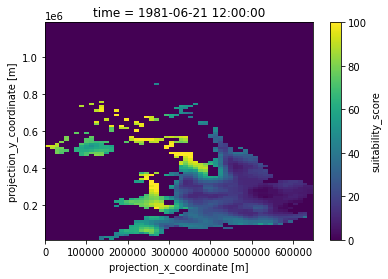

In [127]:
testmax["suitability_score"][200, :, :].plot()

This works.

### Calculations v2

Next step is to adapt it for use with the 1km met data (instead of 12km). Due to the much larger amount of memory used this will need to be run on the JASMIN LOTUS HPC high-mem queue. Will leave an example here.

Precalc stage 1: Calculate the cumulative sums of
- a) Ndays within the optimal T range
- b) Ndays below KTMP
- c) Ndays above KMAX?
- d) Precip

across the entire length of the dataset

Precalcs stage 2 - Use these cumulative sums to calculate the number of days in 
- a) the optimum temperature range, 
- b) the number of days below the killing temperature 
- c) the number of days above the heat killing temperature?
- d) the cumulative precip 

within a given 'growing period' length (GTIME). 

Step 3 - Calculate the suitability score from the files we've generated

Data paths and thresholds

In [48]:
# year to test out script on
year = 2020

# 1 to load metdata, 0 otherwise
loaddata = 0

ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv"
taspath = [
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/tas/chess-scape_rcp85_01_tas_uk_1km_daily_"
    + str(year)
    + "*.nc",
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/tas/chess-scape_rcp85_01_tas_uk_1km_daily_"
    + str(year + 1)
    + "*.nc",
]
prepath = [
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/pr/chess-scape_rcp85_01_pr_uk_1km_daily_"
    + str(year)
    + "*.nc",
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/pr/chess-scape_rcp85_01_pr_uk_1km_daily_"
    + str(year + 1)
    + "*.nc",
]
tmnpath = [
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/tasmin/chess-scape_rcp85_01_tasmin_uk_1km_daily_"
    + str(year)
    + "*.nc",
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/tasmin/chess-scape_rcp85_01_tasmin_uk_1km_daily_"
    + str(year + 1)
    + "*.nc",
]
tmxpath = [
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/tasmax/chess-scape_rcp85_01_tasmax_uk_1km_daily_"
    + str(year)
    + "*.nc",
    "/badc/deposited2021/chess-scape/data/rcp85/01/daily/tasmax/chess-scape_rcp85_01_tasmax_uk_1km_daily_"
    + str(year + 1)
    + "*.nc",
]
tasvname = "tas"
prevname = "pr"
tmnvname = "tasmin"
tmxvname = "tasmax"
savedir = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores_test"
LCMloc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/Mask_arable_LCM2015_UK.tif"
sgmloc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EU_STM_soildata/"
plotdir = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/plots"
cropname = "apple"

ecocropall = pd.read_csv(ecocroploc, engine="python")
ecocrop = ecocropall.drop(["level_0"], axis=1)
testcrop = ecocrop.iloc[
    74, :
]  # 10 asparagus, #19 onions, #117 wheat, #147 chickpea, #66 sweet potato
TOPMIN = testcrop["TOPMN"] + 273.15  # C-->K
TOPMAX = testcrop["TOPMX"] + 273.15  # C-->K
TMIN = testcrop["TMIN"] + 273.15  # C-->K
TMAX = testcrop["TMAX"] + 273.15  # C-->K
PMIN = testcrop["RMIN"] / 86400.0  # mm-->kg/m^2/s
PMAX = testcrop["RMAX"] / 86400.0  # mm-->kg/m^2/s
POPMIN = testcrop["ROPMN"] / 86400.0  # mm-->kg/m^2/s
POPMAX = testcrop["ROPMX"] / 86400.0  # mm-->kg/m^2/s
KTMP = testcrop["KTMPR"] + 273.15  # C-->K
KMAX = testcrop["TMAX"] + 273.15  # C-->K
GMIN = int(testcrop["GMIN"])
GMAX = int(testcrop["GMAX"])
SOIL = testcrop["TEXT"]
COMNAME = testcrop["COMNAME"]
COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
if "(" in COMNAME:
    COMNAME = "".join(COMNAME.split("("))
    COMNAME = "".join(COMNAME.split(")"))
if "'" in COMNAME:
    COMNAME = "".join(COMNAME.split("'"))
cropname = COMNAME

# assume killing temp of -1 if not specified
if np.isnan(KTMP):
    KTMP = -1

print("TMN: " + str(testcrop["TMIN"]))
print("TMX: " + str(testcrop["TMAX"]))
print("TOPMN: " + str(testcrop["TOPMN"]))
print("TOPMX: " + str(testcrop["TOPMX"]))
print("KTMP: " + str(testcrop["KTMPR"]))
print("KMAX: " + str(testcrop["TMAX"]))
print("GMIN: " + str(testcrop["GMIN"]))
print("GMAX: " + str(testcrop["GMAX"]))
print("PMIN: " + str(testcrop["RMIN"]))
print("PMAX: " + str(testcrop["RMAX"]))
print("POPMIN: " + str(testcrop["ROPMN"]))
print("POPMAX: " + str(testcrop["ROPMX"]))
print("SOIL: " + str(SOIL))
print("COMNAME: " + COMNAME)

TMN: 8
TMX: 33
TOPMN: 14
TOPMX: 27
KTMP: -30.0
KMAX: 33
GMIN: 180.0
GMAX: 320
PMIN: 500
PMAX: 3200
POPMIN: 700
POPMAX: 2500
SOIL: medium, light
COMNAME: apple


Annuals method

In [49]:
if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

# open datafiles
if loaddata == 1:
    tasfiles = glob.glob(taspath[0])
    tasfiles.extend(glob.glob(taspath[1]))
    prefiles = glob.glob(prepath[0])
    prefiles.extend(glob.glob(prepath[1]))
    tmxfiles = glob.glob(tmxpath[0])
    tmxfiles.extend(glob.glob(tmxpath[1]))
    tmnfiles = glob.glob(tmnpath[0])
    tmnfiles.extend(glob.glob(tmnpath[1]))

    print("Reading in met data")
    tas = xr.open_mfdataset(tasfiles).astype("float16")[tasvname].load()
    tmn = xr.open_mfdataset(tmnfiles).astype("float16")[tmnvname].load()
    tmx = xr.open_mfdataset(tmxfiles).astype("float16")[tmxvname].load()
    pre = xr.open_mfdataset(prefiles)[prevname].load()

    tastime = tas["time"]
    tasy = tas["y"]
    tasx = tas["x"]

    # tas = tas.values

print(
    "Calculating where/when temperature is below/above frost and heat stress thresholds"
)
topt_crop = score_temp2(tas, TMIN, TMAX, TOPMIN, TOPMAX).values
ktmp_crop = xr.where(tmn < KTMP, 1, 0).astype("uint16").values
kmax_crop = xr.where(tmx > KMAX, 1, 0).astype("uint16").values

gstart = np.int16(np.ceil(GMIN / 10) * 10)
gend = np.int16(np.ceil(GMAX / 10) * 10)
allgtimes = list(np.arange(gstart, gend, 10, dtype="int16"))

counter = 1
GMIN = np.uint16(GMIN)
GMAX = np.uint16(GMAX)
for gtime in allgtimes:
    print(
        "Calculating suitability for "
        + COMNAME
        + " for a growing season of length "
        + str(gtime)
        + " out of a maximum of "
        + str(int(GMAX))
    )

    tscore1 = score_temp(gtime, GMIN, GMAX).astype("uint8")

    # score T based on proportion of days in gtime in/close to optimum
    print("Calculating T suitability")
    tcoords_tas = tastime[: -gtime + 1]
    ycoords_tas = tasy
    xcoords_tas = tasx
    toptdays = (frs3D(topt_crop, gtime, "float32")).round().astype("uint16")
    toptdays = xr.DataArray(toptdays, coords=[tcoords_tas, ycoords_tas, xcoords_tas])
    toptdays.name = "TOPT_days"
    tscore = xr.where(toptdays >= GMIN, tscore1, np.uint8(0))

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp within gtime
    print("Calculating KTMP days")
    tcoords_tmn = tmn["time"][: -gtime + 1]
    ycoords_tmn = tmn["y"]
    xcoords_tmn = tmn["x"]
    ktmp_days = frs3D(ktmp_crop, gtime, "uint16")
    ktmp_days = xr.DataArray(ktmp_days, coords=[tcoords_tmn, ycoords_tmn, xcoords_tmn])
    ktmp_days.name = "KTMP_days"

    # calculate whether any of the suitable days/locations identified above will have
    # heat killing temp within gtime
    print("Calculating KMAX days")
    tcoords_tmx = tmx["time"][: -gtime + 1]
    ycoords_tmx = tmx["y"]
    xcoords_tmx = tmx["x"]
    kmax_days = frs3D(kmax_crop, gtime, "uint16")
    kmax_days = xr.DataArray(kmax_days, coords=[tcoords_tmx, ycoords_tmx, xcoords_tmx])
    kmax_days.name = "KMAX_days"

    # calculate total precipitation in gtime
    print("Calculating total precip")
    tcoords_pre = pre["time"][: -gtime + 1]
    ycoords_pre = pre["y"]
    xcoords_pre = pre["x"]
    pre2 = pre.values
    precip_crop = frs3D(pre2, gtime, "float32")
    precip_crop = xr.DataArray(
        precip_crop, coords=[tcoords_pre, ycoords_pre, xcoords_pre]
    )
    precip_crop.name = "precip_total"

    print("Processing KTMP")
    tempscore = xr.where(ktmp_days > np.uint8(0), np.uint8(0), tscore)

    print("Processing KMAX days penalty")
    tempscore = tempscore - np.int8(kmax_days)
    tempscore = xr.where(tempscore < 0, 0, tempscore).astype("uint8")

    print("Calculating precip suitability score")
    precscore = score_prec2(precip_crop, PMIN, PMAX, POPMIN, POPMAX)

    print("Updating T & P suitability scores")
    if counter == 1:
        tempscore_old = tempscore
        precscore_old = precscore
    else:
        if len(tempscore_old["time"]) > len(tempscore["time"]):
            tempscore_old = tempscore_old.sel(
                time=slice(tempscore["time"][0], tempscore["time"][-1])
            )
        if len(precscore_old["time"]) > len(precscore["time"]):
            precscore_old = precscore_old.sel(
                time=slice(precscore["time"][0], precscore["time"][-1])
            )
        tempscore = xr.where(
            tempscore > tempscore_old, tempscore, tempscore_old
        )  # .astype('uint8')
        precscore = xr.where(
            precscore > precscore_old, precscore, precscore_old
        )  # .astype('uint8')

        tempscore_old = tempscore
        precscore_old = precscore

    counter += 1

final_score_crop = xr.where(precscore < tempscore, precscore, tempscore)
final_score_crop.name = "crop_suitability_score"
final_score_crop.encoding["zlib"] = True
final_score_crop.encoding["complevel"] = 1
final_score_crop.encoding["shuffle"] = False
final_score_crop.encoding["contiguous"] = False
final_score_crop.encoding["dtype"] = np.dtype("uint8")
encoding = {}
encoding["crop_suitability_score"] = final_score_crop.encoding
final_score_crop.to_netcdf(os.path.join(savedir, cropname + ".nc"), encoding=encoding)

tempscore.name = "temperature_suitability_score"
tempscore.encoding["zlib"] = True
tempscore.encoding["complevel"] = 1
tempscore.encoding["shuffle"] = False
tempscore.encoding["contiguous"] = False
tempscore.encoding["dtype"] = np.dtype("uint8")
encoding = {}
encoding["temperature_suitability_score"] = tempscore.encoding
tempscore.to_netcdf(os.path.join(savedir, cropname + "_temp.nc"), encoding=encoding)

precscore.name = "precip_suitability_score"
precscore.encoding["zlib"] = True
precscore.encoding["complevel"] = 1
precscore.encoding["shuffle"] = False
precscore.encoding["contiguous"] = False
precscore.encoding["dtype"] = np.dtype("uint8")
encoding = {}
encoding["precip_suitability_score"] = precscore.encoding
precscore.to_netcdf(os.path.join(savedir, cropname + "_prec.nc"), encoding=encoding)

tempscore_years = tempscore.groupby("time.year").quantile(0.95)
precscore_years = precscore.groupby("time.year").quantile(0.95)
allscore_years = xr.where(
    precscore_years < tempscore_years, precscore_years, tempscore_years
)

lcm2 = xr.open_rasterio(LCMloc)
lcm = lcm2.drop("band").squeeze()
lcm = lcm[::-1, :]
allscore_years = lcm_mask(lcm, allscore_years)
tempscore_years = lcm_mask(lcm, tempscore_years)
precscore_years = lcm_mask(lcm, precscore_years)
allscore_years = soil_type_mask_all(allscore_years, SOIL, sgmloc)
tempscore_years = soil_type_mask_all(tempscore_years, SOIL, sgmloc)
precscore_years = soil_type_mask_all(precscore_years, SOIL, sgmloc)

Calculating where/when temperature is below/above frost and heat stress thresholds
Calculating suitability for apple for a growing season of length 180 out of a maximum of 320
Calculating T suitability
Calculating KTMP days
Calculating KMAX days
Calculating total precip
Processing KTMP
Processing KMAX days penalty
Calculating precip suitability score
Updating T & P suitability scores
Calculating suitability for apple for a growing season of length 190 out of a maximum of 320
Calculating T suitability
Calculating KTMP days
Calculating KMAX days
Calculating total precip
Processing KTMP
Processing KMAX days penalty
Calculating precip suitability score
Updating T & P suitability scores
Calculating suitability for apple for a growing season of length 200 out of a maximum of 320
Calculating T suitability
Calculating KTMP days
Calculating KMAX days
Calculating total precip
Processing KTMP
Processing KMAX days penalty
Calculating precip suitability score
Updating T & P suitability scores
Calcu

In [50]:
tscore.dtype

dtype('uint8')

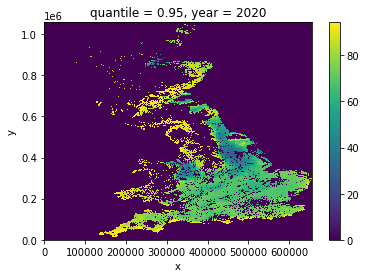

In [41]:
allscore_years[0].plot()

In [36]:
lcm["y"]

<xarray.DataArray 'y' (y: 1300)>
array([5.0000e+02, 1.5000e+03, 2.5000e+03, ..., 1.2975e+06, 1.2985e+06,
       1.2995e+06])
Coordinates:
  * y        (y) float64 500.0 1.5e+03 2.5e+03 ... 1.298e+06 1.298e+06 1.3e+06

In [30]:
allscore_years["y"]

<xarray.DataArray 'y' (y: 1057)>
array([5.0000e+02, 1.5000e+03, 2.5000e+03, ..., 1.0545e+06, 1.0555e+06,
       1.0565e+06], dtype=float32)
Coordinates:
  * y         (y) float32 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
    quantile  float64 0.95

Perennials method

In [ ]:
if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

# open datafiles
if loaddata == 1:
    print("Reading in met data")
    tas = xr.open_mfdataset(taspath).astype("float16")[tasvname].load()
    tmn = xr.open_mfdataset(tmnpath).astype("float16")[tmnvname].load()
    tmx = xr.open_mfdataset(tmxpath).astype("float16")[tmxvname].load()
    pre = xr.open_mfdataset(prepath)[prevname].load()

    tastime = tas["time"]
    tasy = tas["y"]
    tasx = tas["x"]

    tas = tas.values

print(
    "Calculating where/when temperature is below/above frost and heat stress thresholds"
)
# topt_crop = score_temp2(tas, TMIN, TMAX, TOPMIN, TOPMAX).values
ktmp_crop = xr.where(tmn < KTMP, 1, 0).astype("uint16").values
kmax_crop = xr.where(tmx > KMAX, 1, 0).astype("uint16").values

gstart = np.int16(np.ceil(GMIN / 10) * 10)
gend = np.int16(np.ceil(GMAX / 10) * 10)
allgtimes = list(np.arange(gstart, gend, 10, dtype="int16"))

counter = 1
GMIN = np.uint16(GMIN)
GMAX = np.uint16(GMAX)
for gtime in allgtimes:
    print(
        "Calculating suitability for "
        + COMNAME
        + " for a growing season of length "
        + str(gtime)
        + " out of a maximum of "
        + str(int(GMAX))
    )

    # score T based on proportion of days in gtime in/close to optimum
    print("Calculating T suitability")
    tcoords_tas = tastime[: -gtime + 1]
    ycoords_tas = tasy
    xcoords_tas = tasx
    toptdays = (frs3D(tas, gtime, "float32") / gtime).round().astype("uint16")
    toptdays = xr.DataArray(toptdays, coords=[tcoords_tas, ycoords_tas, xcoords_tas])
    toptdays.name = "TOPT_days"
    tscore = score_temp3(toptdays, TMIN, TMAX, TOPMIN, TOPMAX)

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp within gtime
    print("Calculating KTMP days")
    tcoords_tmn = tmn["time"][: -gtime + 1]
    ycoords_tmn = tmn["y"]
    xcoords_tmn = tmn["x"]
    ktmp_days = frs3D(ktmp_crop, gtime, "uint16")
    ktmp_days = xr.DataArray(ktmp_days, coords=[tcoords_tmn, ycoords_tmn, xcoords_tmn])
    ktmp_days.name = "KTMP_days"

    # calculate whether any of the suitable days/locations identified above will have
    # heat killing temp within gtime
    print("Calculating KMAX days")
    tcoords_tmx = tmx["time"][: -gtime + 1]
    ycoords_tmx = tmx["y"]
    xcoords_tmx = tmx["x"]
    kmax_days = frs3D(kmax_crop, gtime, "uint16")
    kmax_days = xr.DataArray(kmax_days, coords=[tcoords_tmx, ycoords_tmx, xcoords_tmx])
    kmax_days.name = "KMAX_days"

    # calculate total precipitation in gtime
    print("Calculating total precip")
    tcoords_pre = pre["time"][: -gtime + 1]
    ycoords_pre = pre["y"]
    xcoords_pre = pre["x"]
    pre2 = pre.values
    precip_crop = frs3D(pre2, gtime, "float32")
    precip_crop = xr.DataArray(
        precip_crop, coords=[tcoords_pre, ycoords_pre, xcoords_pre]
    )
    precip_crop.name = "precip_total"

    print("Processing KTMP")
    tempscore = xr.where(ktmp_days > np.uint8(0), np.uint8(0), tscore)

    print("Processing KMAX days penalty")
    tempscore = tempscore - np.int8(kmax_days)
    tempscore = xr.where(tempscore < 0, 0, tempscore).astype("uint8")

    print("Calculating precip suitability score")
    precscore = score_prec2(precip_crop, PMIN, PMAX, POPMIN, POPMAX)

    print("Updating T & P suitability scores")
    if counter == 1:
        tempscore_old = tempscore
        precscore_old = precscore
    else:
        if len(tempscore_old["time"]) > len(tempscore["time"]):
            tempscore_old = tempscore_old.sel(
                time=slice(tempscore["time"][0], tempscore["time"][-1])
            )
        if len(precscore_old["time"]) > len(precscore["time"]):
            precscore_old = precscore_old.sel(
                time=slice(precscore["time"][0], precscore["time"][-1])
            )
        tempscore = xr.where(
            tempscore > tempscore_old, tempscore, tempscore_old
        )  # .astype('uint8')
        precscore = xr.where(
            precscore > precscore_old, precscore, precscore_old
        )  # .astype('uint8')

        tempscore_old = tempscore
        precscore_old = precscore

    counter += 1

final_score_crop = xr.where(precscore < tempscore, precscore, tempscore)
final_score_crop.name = "crop_suitability_score"
final_score_crop.encoding["zlib"] = True
final_score_crop.encoding["complevel"] = 1
final_score_crop.encoding["shuffle"] = False
final_score_crop.encoding["contiguous"] = False
final_score_crop.encoding["dtype"] = np.dtype("uint8")
encoding = {}
encoding["crop_suitability_score"] = final_score_crop.encoding
final_score_crop.to_netcdf(os.path.join(savedir, cropname + ".nc"), encoding=encoding)

tempscore.name = "temperature_suitability_score"
tempscore.encoding["zlib"] = True
tempscore.encoding["complevel"] = 1
tempscore.encoding["shuffle"] = False
tempscore.encoding["contiguous"] = False
tempscore.encoding["dtype"] = np.dtype("uint8")
encoding = {}
encoding["temperature_suitability_score"] = tempscore.encoding
tempscore.to_netcdf(os.path.join(savedir, cropname + "_temp.nc"), encoding=encoding)

precscore.name = "precip_suitability_score"
precscore.encoding["zlib"] = True
precscore.encoding["complevel"] = 1
precscore.encoding["shuffle"] = False
precscore.encoding["contiguous"] = False
precscore.encoding["dtype"] = np.dtype("uint8")
encoding = {}
encoding["precip_suitability_score"] = precscore.encoding
precscore.to_netcdf(os.path.join(savedir, cropname + "_prec.nc"), encoding=encoding)

----

In [56]:
cropname = "wheat"
allscore_years = xr.load_dataset("scores_rcp85_ens01_a2020/" + cropname + "_years.nc")[
    "crop_suitability_score"
]
tempscore_years = xr.load_dataset(
    "scores_rcp85_ens01_a2020/" + cropname + "_tempscore_years.nc"
)["temperature_suitability_score"]
precscore_years = xr.load_dataset(
    "scores_rcp85_ens01_a2020/" + cropname + "_precscore_years.nc"
)["precip_suitability_score"]

allscore_decades = xr.load_dataset(
    "scores_rcp85_ens01_a2020/" + cropname + "_decadal_changes.nc"
)["crop_suitability_score"]
tempscore_decades = xr.load_dataset(
    "scores_rcp85_ens01_a2020/" + cropname + "_tempscore_decadal_changes.nc"
)["temperature_suitability_score"]
precscore_decades = xr.load_dataset(
    "scores_rcp85_ens01_a2020/" + cropname + "_precscore_decadal_changes.nc"
)["precip_suitability_score"]

In [113]:
print("PMIN: " + str(testcrop["RMIN"]))
print("PMAX: " + str(testcrop["RMAX"]))
print("POPMIN: " + str(testcrop["ROPMN"]))
print("POPMAX: " + str(testcrop["ROPMX"]))

PMIN: 300.0
PMAX: 1600.0
POPMIN: 750.0
POPMAX: 900.0


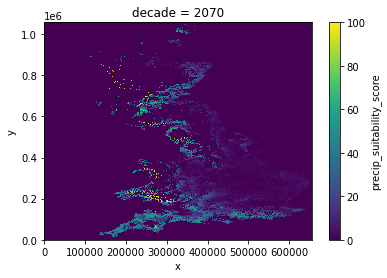

In [118]:
precscore_decades[5, :, :].plot()

Plot decadal change

In [59]:
plot_decadal_changes(
    allscore_decades, save="plots_test/" + cropname + "_decadal_changes.png"
)

36.0
-19.0


/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:571: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  fig, axs = plt.subplots(1,3, subplot_kw={'projection': cp.crs.OSGB()})


In [61]:
plot_decadal_changes(
    tempscore_decades, save="plots_test/" + cropname + "_decadal_changes_temp.png"
)

36.0
-20.0


/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:571: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  fig, axs = plt.subplots(1,3, subplot_kw={'projection': cp.crs.OSGB()})


In [62]:
plot_decadal_changes(
    precscore_decades, save="plots_test/" + cropname + "_decadal_changes_prec.png"
)

19.0
-20.0


/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:571: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  fig, axs = plt.subplots(1,3, subplot_kw={'projection': cp.crs.OSGB()})


--------------

In [106]:
cropname = "wheat"
allscore_decades = xr.load_dataset("scores_old/" + cropname + "_decades.nc")[
    "crop_suitability_score"
]
tempscore_decades = xr.load_dataset("scores_old/" + cropname + "_tempscore_decades.nc")[
    "temperature_suitability_score"
]
precscore_decades = xr.load_dataset("scores_old/" + cropname + "_precscore_decades.nc")[
    "precip_suitability_score"
]

In [107]:
allscore_2020s = allscore_decades[0, :, :]
tempscore_2020s = tempscore_decades[0, :, :]
precscore_2020s = precscore_decades[0, :, :]

allscore_2020s = allscore_2020s.where(allscore_2020s > 0)
tempscore_2020s = tempscore_2020s.where(tempscore_2020s > 0)
precscore_2020s = precscore_2020s.where(precscore_2020s > 0)

Text(0.5, 1.0, '2020 precscore')

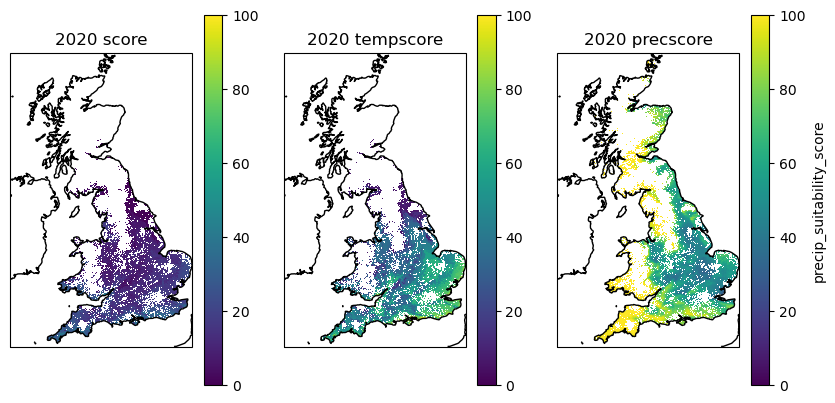

In [108]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": cp.crs.OSGB()})
fig.set_figwidth(10)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax1.coastlines(resolution="10m")
ax2.coastlines(resolution="10m")
ax3.coastlines(resolution="10m")

allscore_2020s.plot(ax=ax1, vmin=0, vmax=100)
tempscore_2020s.plot(ax=ax2, vmin=0, vmax=100)
precscore_2020s.plot(ax=ax3, vmin=0, vmax=100)

cbarax1 = ax1.collections[0].colorbar.ax
cbarax2 = ax2.collections[0].colorbar.ax
cbarax3 = ax2.collections[0].colorbar.ax
cbarax1.set_ylabel("")
cbarax2.set_ylabel("")
cbarax3.set_ylabel("")

ax1.set_title("2020 score")
ax2.set_title("2020 tempscore")
ax3.set_title("2020 precscore")

### Testing different score aggregation methods

At the moment we take the maximum over each year which minimizes the impact of days with low suitability. First thing to try is the 95th percentile.

In [2]:
score = xr.load_dataset("scores_tmethod_tests3/wheat_temp.nc").sel(
    time=slice("2020-01-01", "2030-01-01")
)

In [38]:
score_year_90 = score.groupby("time.year").quantile(0.90)

In [4]:
score_year_max = xr.load_dataset("scores_tmethod_tests3/wheat_tempscore_years.nc").sel(
    year=slice(2020, 2030)
)

In [43]:
score_year_90_test = score_year_90["temperature_suitability_score"][1, :, :]
score_year_max_test = score_year_max["temperature_suitability_score"][1, :, :]

<IPython.core.display.Javascript object>


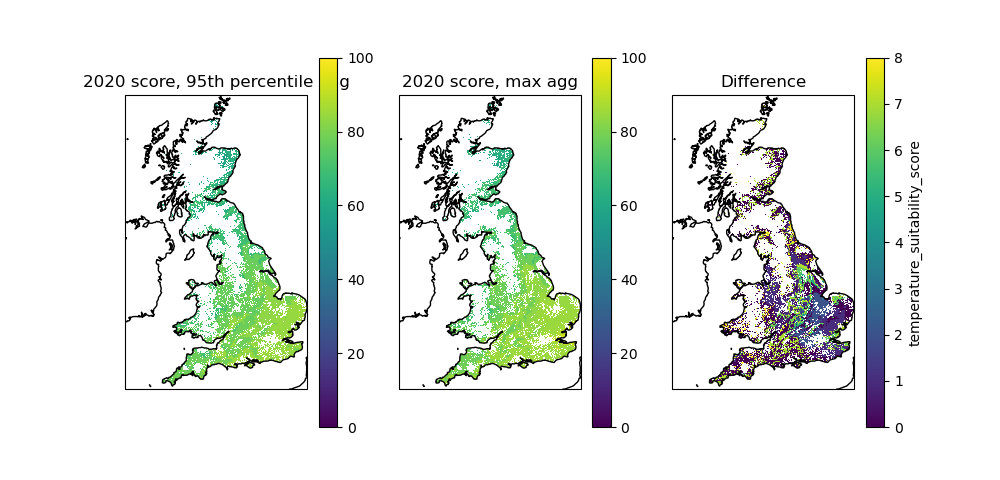

Text(0.5, 1.0, 'Difference')

In [44]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": cp.crs.OSGB()})
fig.set_figwidth(10)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax1.coastlines(resolution="10m")
ax2.coastlines(resolution="10m")
ax3.coastlines(resolution="10m")

score_year_95_test = score_year_90_test.where(score_year_max_test > 0)
score_year_max_test = score_year_max_test.where(score_year_max_test > 0)
score_year_diff = score_year_max_test - score_year_95_test

score_year_95_test.plot(ax=ax1, vmin=0, vmax=100)
score_year_max_test.plot(ax=ax2, vmin=0, vmax=100)
score_year_diff.plot(ax=ax3)

cbarax1 = ax1.collections[0].colorbar.ax
cbarax2 = ax2.collections[0].colorbar.ax
cbarax3 = ax2.collections[0].colorbar.ax
cbarax1.set_ylabel("")
cbarax2.set_ylabel("")
cbarax3.set_ylabel("")

ax1.set_title("2020 score, 95th percentile agg")
ax2.set_title("2020 score, max agg")
ax3.set_title("Difference")

Histogram of test year at point with big diff

In [6]:
yearpoint = score.sel(time=slice("2020-01-01", "2021-01-01")).sel(
    x=364000, y=862000, method="nearest"
)["temperature_suitability_score"]

In [8]:
print("95th %ile: " + str(yearpoint.quantile(0.95).values))
print("Max: " + str(yearpoint.max().values))

95th %ile: 70.0
Max: 78


(array([29., 50., 39., 40., 41., 33., 36., 38., 37., 18.]),
 array([13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. , 71.5, 78. ]),
 <BarContainer object of 10 artists>)

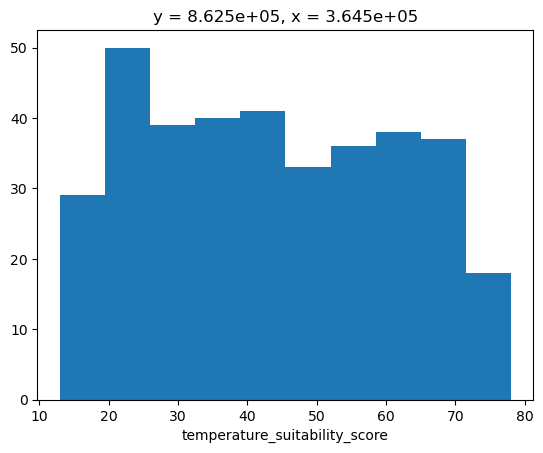

In [9]:
yearpoint.plot.hist()

Histogram of test year at point with small diff

In [11]:
yearpoint = score.sel(time=slice("2020-01-01", "2021-01-01")).sel(
    x=383000, y=649000, method="nearest"
)["temperature_suitability_score"]

In [25]:
print(
    "95th %ile: "
    + str(yearpoint.quantile(0.95, method="interpolated_inverted_cdf").values)
)
print("Max: " + str(yearpoint.max().values))

95th %ile: 81.0
Max: 81


(array([15., 49., 35., 53., 37., 31., 29., 38., 34., 40.]),
 array([13. , 19.8, 26.6, 33.4, 40.2, 47. , 53.8, 60.6, 67.4, 74.2, 81. ]),
 <BarContainer object of 10 artists>)

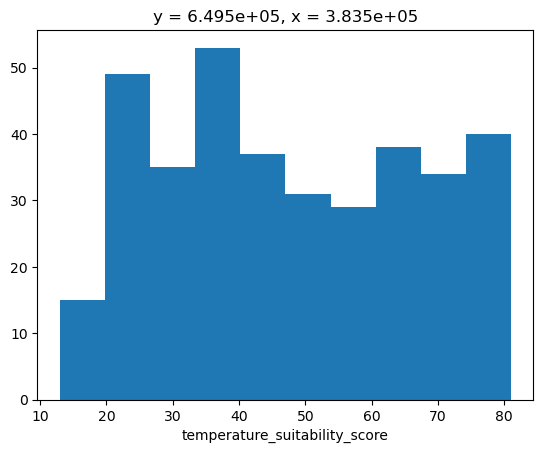

In [15]:
yearpoint.plot.hist()

The distribution looks like:

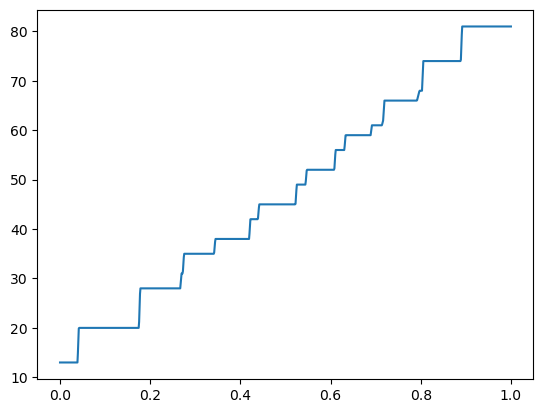

In [37]:
x = np.linspace(0, 1, 1010)
y1 = [yearpoint.quantile(q).values for q in x]
plt.plot(x, y1)

I don't think there's any way around the blockiness/stepiness of it. So 95th quantile it is.

### Calculations v3

Trying with numba - not as fast now that I've solved the dask issue. Kept for reference.

In [2]:
ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv"
taspath = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/tasmean/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tas_bias_corrected_????.nc"
prepath = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/pr/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_????.nc"
tmxpath = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/tasmax/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tasmax_bias_corrected_????.nc"
tmnpath = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/metdata/UKCP18_BC_01/tasmin/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_tasmin_bias_corrected_????.nc"
tasvname = "tas"
prevname = "pr"
tmxvname = "tasmax"
tmnvname = "tasmin"
outdir = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/outputs/"
year = "2020"

In [3]:
ecocropall = pd.read_csv(ecocroploc, engine="python")
ecocrop = ecocropall.drop(["level_0"], axis=1)
testcrop = ecocrop.iloc[19, :]  # onions
TOPMIN = testcrop["TOPMN"]
TOPMAX = testcrop["TOPMX"]
PMIN = testcrop["RMIN"]
PMAX = testcrop["RMAX"]
POPMIN = testcrop["ROPMN"]
POPMAX = testcrop["ROPMX"]
KTMP = testcrop["KTMPR"]
GMIN = testcrop["GMIN"]
GMAX = testcrop["GMAX"]
COMNAME = testcrop["COMNAME"]
# assume killing temp of -1 if not specified
if np.isnan(KTMP):
    KTMP = -1

In [2]:
# Function that does a forward rolling sum without loops
# see https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
# can't be used with numba as it doesn't support cumsum on n-d arrays
def frs3D(indata, window):
    ret = np.cumsum(indata, axis=-1)
    ret[:, :, window:] = ret[:, :, window:] - ret[:, :, :-window]
    return ret[:, :, (window - 1) :]

In [4]:
@njit(parallel=True)
def csscore(tas, tmx, tmn, pre, gtime, TOPMIN, TOPMAX, KTMP, GMIN, GMAX, PMIN, PMAX):
    tdimlen = tas.shape[2]
    ydimlen = tas.shape[0]
    xdimlen = tas.shape[1]
    toptdays_crop = np.zeros((ydimlen, xdimlen, tdimlen - gtime + 1), dtype=np.uint16)
    ktmp_days = np.zeros((ydimlen, xdimlen, tdimlen - gtime + 1), dtype=np.uint16)
    precip_crop = np.zeros((ydimlen, xdimlen, tdimlen - gtime + 1), dtype=np.uint16)

    # convert units from K-->C and kg/m^2/s-->mm/day
    print("Converting units")
    tas = tas - 273.15
    tmx = tmx - 273.15
    tmn = tmn - 273.15
    pre = pre * 86400

    print("Doing calculations")
    print("First set of np.where calculations")
    # calculate days where temperature is within range of crop
    tmaxopt_crop = np.where(tas < TOPMAX, 0.5, 0)
    tminopt_crop = np.where(tas > TOPMIN, 0.5, 0)
    topt_crop = tmaxopt_crop + tminopt_crop
    topt_crop = np.where(topt_crop == 1, topt_crop, 0)

    # calculate days where temperature is below killing temperature of crop
    ktmp_crop = np.where(tmn < KTMP, 1, 0)

    # calculate where GMIN days of T in optimal range is satisfied with growing window of gtime
    # toptdays_crop = topt_crop[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    print("First rolling calc")
    # t=0
    # print(topt_crop[:,:,t:t+gtime].sum(axis=2).shape)
    # print(toptdays_crop[:,:,t].shape)
    for t in prange(0, tdimlen - gtime + 1):
        toptdays_crop[:, :, t] = topt_crop[:, :, t : t + gtime].sum(axis=2)
    # toptdays_crop = frs3D(topt_crop, gtime)
    print("Second set of np.where calculations")
    suit_crop = np.where(toptdays_crop >= GMIN, 1, 0)
    print(suit_crop.shape)

    # calculate whether any of the suitable days/locations identified above will have
    # frost/killing temp in their growing window, and set suitability to 0 if so
    # ktmp_days = ktmp_crop[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    print("Second rolling calc")
    for t in prange(0, tdimlen - gtime + 1):
        ktmp_days[:, :, t] = ktmp_crop[:, :, t : t + gtime].sum(axis=2)
    # ktmp_days = frs3D(ktmp_crop, gtime)
    print("Third set of np.where calculations")
    suit_crop2 = np.where(ktmp_days > 0, 0, suit_crop)

    # calculate total precipitation in the growing window and mask out any of the
    # suitable locations/days identified above if not within range for crop
    # precip_crop = pre[::-1,:,:].rolling(time=gtime).sum()[::-1,:,:]
    print("Third rolling calc")
    for t in prange(0, tdimlen - gtime + 1):
        precip_crop[:, :, t] = pre[:, :, t : t + gtime].sum(axis=2)
    # precip_crop = frs3D(pre, gtime)
    print("Last set of np.where calculations")
    precip_suit = np.where(precip_crop > PMIN, suit_crop2, 0)
    precip_suit = np.where(precip_crop < PMAX, precip_suit, 0)
    precip_suit_total = np.where(precip_suit > 0, precip_crop, 0)

    # calculate the suitability scores for temp and precip
    tempscore = np.where(precip_suit > 0, score_temp(gtime, GMIN, GMAX), 0)
    precscore = score_prec(
        np.where(precip_suit_total > 0, precip_suit_total, np.nan),
        PMIN,
        PMAX,
        POPMIN,
        POPMAX,
    )

    # calculate final suitability score (take minimum of temp and precip scores)
    final_score_crop = np.where(precscore < tempscore, precscore, tempscore)

    return final_score_crop

In [5]:
%%time
comname = "_".join(COMNAME.split(" "))
comname = "".join(comname.split("("))
comname = "".join(comname.split(")"))

if not os.path.exists(outdir):
    os.makedirs(outdir)

gtime = int(GMIN) + 30
print(
    "Calculating suitability for "
    + comname
    + " for a growing season of length "
    + str(gtime)
    + " out of a maximum of "
    + str(int(GMAX))
)

# open datafiles
nyer = str(int(year) + 1)
print("Reading in met data")
tas1 = xr.load_dataset(year.join(taspath.split("????")))[tasvname]
tas2 = xr.load_dataset(nyer.join(taspath.split("????")))[tasvname]
pre1 = xr.load_dataset(year.join(prepath.split("????")))[prevname]
pre2 = xr.load_dataset(nyer.join(prepath.split("????")))[prevname]
tmx1 = xr.load_dataset(year.join(tmxpath.split("????")))[tmxvname]
tmx2 = xr.load_dataset(nyer.join(tmxpath.split("????")))[tmxvname]
tmn1 = xr.load_dataset(year.join(tmnpath.split("????")))[tmnvname]
tmn2 = xr.load_dataset(nyer.join(tmnpath.split("????")))[tmnvname]
tasx = xr.concat([tas1, tas2], dim="time")
prex = xr.concat([pre1, pre2], dim="time")
tmxx = xr.concat([tmx1, tmx2], dim="time")
tmnx = xr.concat([tmn1, tmn2], dim="time")
tdimlen = tasx.shape[0]
tcoords = tasx["time"][: tdimlen - gtime + 1]
ycoords = tasx["y"]
xcoords = tasx["x"]

tas = tasx.values.transpose((1, 2, 0))
pre = prex.values.transpose((1, 2, 0))
tmx = tmxx.values.transpose((1, 2, 0))
tmn = tmnx.values.transpose((1, 2, 0))
print(tas.shape)

Calculating suitability for Onions_bulb for a growing season of length 115 out of a maximum of 175
Reading in met data
(1057, 656, 720)
CPU times: user 29.2 s, sys: 25.7 s, total: 54.9 s
Wall time: 4min 30s


In [6]:
start = dt.datetime.now()
final_score_crop = csscore(
    tas, tmx, tmn, pre, gtime, TOPMIN, TOPMAX, KTMP, GMIN, GMAX, PMIN, PMAX
)
end = dt.datetime.now()
print(end - start)

final_score_crop_xr = xr.DataArray(final_score_crop, coords=[ycoords, xcoords, tcoords])
final_score_crop_xr.name = "crop_suitability_score"
final_score_crop_xr.encoding["zlib"] = True
final_score_crop_xr.encoding["complevel"] = 1
final_score_crop_xr.encoding["shuffle"] = False
final_score_crop_xr.encoding["contiguous"] = False
final_score_crop_xr.encoding["dtype"] = np.dtype("uint16")
encoding = {}
encoding["crop_suitability_score"] = final_score_crop_xr.encoding
filepath = os.path.join(
    outdir, "final_score_crop_" + comname + "_glen" + str(gtime) + ".nc"
)
final_score_crop_xr.to_netcdf(filepath, encoding=encoding)

<ipython-input-4-b720dcb81735>:64: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "ecocrop_utils.py", line 15:
@njit(parallel=True)
def score_temp(gtime, gmin, gmax):
^

  tempscore = np.where(precip_suit > 0, score_temp(gtime, GMIN, GMAX), 0)


Converting units
Doing calculations
First set of np.where calculations
First rolling calc
Second set of np.where calculations
(1057, 656, 606)
Second rolling calc
Third set of np.where calculations
Third rolling calc
Last set of np.where calculations
0:06:22.267979


/home/users/mattjbr/anaconda3/envs/ecocrop/lib/python3.9/site-packages/xarray/core/dataarray.py:2778: SerializationWarning: saving variable crop_suitability_score with floating point data as an integer dtype without any _FillValue to use for NaNs
  return dataset.to_netcdf(*args, **kwargs)


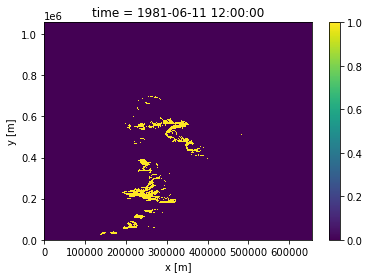

In [6]:
precip_suit[160, :, :].plot()

In [38]:
%matplotlib notebook

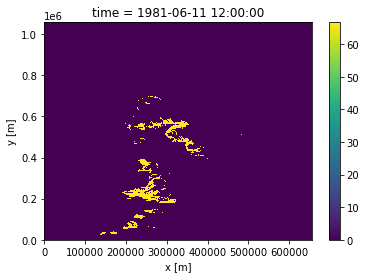

In [8]:
tempscore[160, :, :].plot()

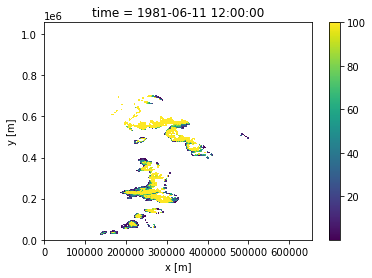

In [9]:
precscore[160, :, :].plot()

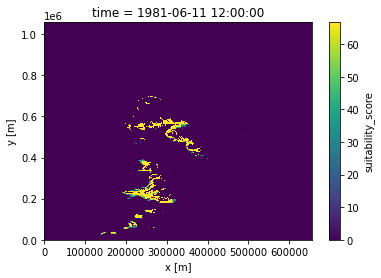

In [10]:
final_score_crop[160, :, :].plot()

Test plots when running for the entire 100year dataset at once

In [2]:
%matplotlib notebook

In [2]:
final_score_crop = xr.open_dataset(
    "/gws/nopw/j04/ceh_generic/matbro/ecocrop/outputs/final_score_crop_Onions_bulb_glen115.nc"
).chunk({"time": 360})["suitability_score"]

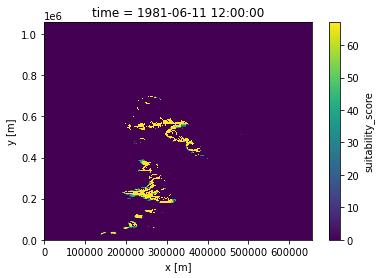

In [11]:
test = final_score_crop[160, :, :]
test = test.where(test < 65535)
test.plot()

### Plotting possible precip scoring graphs

In [36]:
ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv"
ecocropall = pd.read_csv(ecocroploc, engine="python")
ecocrop = ecocropall.drop(["level_0"], axis=1)
for c in range(0, ecocrop.shape[0]):
    testcrop = ecocrop.iloc[
        c, :
    ]  # 19 onions, #117 wheat, #147 chickpea, #66 sweet potato
    PMIN = testcrop["RMIN"]
    PMAX = testcrop["RMAX"]
    POPMIN = testcrop["ROPMN"]
    POPMAX = testcrop["ROPMX"]
    COMNAME = testcrop["COMNAME"]
    try:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        cropname = COMNAME
    except AttributeError:
        continue

    print("Plotting pscore for " + cropname)
    if np.isnan(testcrop["RMIN"]):
        continue
    if np.isnan(testcrop["RMAX"]):
        continue
    if np.isnan(testcrop["ROPMN"]):
        continue
    if np.isnan(testcrop["ROPMX"]):
        continue

    plot_pscore(cropname, PMIN, POPMIN, POPMAX, PMAX)

Plotting pscore for abelmoskus
Plotting pscore for Ellington_curse
Plotting pscore for New_Zealand_kauri
Plotting pscore for wild_leek
Plotting pscore for onion
Plotting pscore for branching_onion
Plotting pscore for garlic
Plotting pscore for whitespot
Plotting pscore for wild_celery
Plotting pscore for celery
Plotting pscore for asparagus
Plotting pscore for oat
Plotting pscore for common_bamboo
Plotting pscore for Silver_beet
Plotting pscore for blue_grass
Plotting pscore for bread_grass
Plotting pscore for kurrajong
Plotting pscore for Chinese_cabbage
Plotting pscore for Indian_mustard
Plotting pscore for Onions_bulb
Plotting pscore for cauliflower
Plotting pscore for cabbage
Plotting pscore for Brussels_sprouts
Plotting pscore for broccoli
Plotting pscore for Chinese_chives
Plotting pscore for tea
Plotting pscore for jack_bean
Plotting pscore for sweet_pepper
Plotting pscore for cayenne_pepper
Plotting pscore for periwinkle
Plotting pscore for African_foxtail
Plotting pscore for e

Plotting pscore for red_ironbark
Plotting pscore for Tasmanian_ironbark
Plotting pscore for white_gum_tree
Plotting pscore for American_beech
Plotting pscore for tall_fescue
Plotting pscore for Idaho_fescue
Plotting pscore for Moreton_Bay_fig
Plotting pscore for dwarf_kumquat
Plotting pscore for Chilean_strawberry
Plotting pscore for Virginia_strawberry
Plotting pscore for buckthorn
Plotting pscore for dyers-greenweed
Plotting pscore for honey-locust
Plotting pscore for sulla
Plotting pscore for vanilla_grass
Plotting pscore for sea_buckthorn
Plotting pscore for bulbous_barley
Plotting pscore for hop
Plotting pscore for dom_Sudan
Plotting pscore for hyssop
Plotting pscore for European_larch
Plotting pscore for chickling_vetch
Plotting pscore for true_lavender
Plotting pscore for French_lavender
Plotting pscore for lavandin
Plotting pscore for lentil
Plotting pscore for meadowfoam
Plotting pscore for flax
Plotting pscore for annual_ryegrass
Plotting pscore for birds-foot_trefoil
Plottin

Both options 2 and 3 are better than option 1 as we gain resolution on the precip score changes - it doesn't saturate out at 100. The question is which is better? Or is there a further option?

- For the cases where the optimum range is much smaller than the total range, the score incurs a greater penalty for not being within the optimum range with option 3
- For the cases where the optimum range is greater than half the total range, the score incurs *less* of a penalty for not being within the optimum range with option 3, but I don't think this is so important

The choice is between:
- Is it more important that the crop is in the optimum range?
- Is it more important that the crop is near the middle of the optimum range?


- I think option 3 is more consistent in terms of how it treats the optimum section, but runs the risk of generating large changes in suitability when the optimum range is much narrower than the total range.
- However, I prefer option 2 in the cases where the optimum range is small (relative to the total range) and much closer to the lower end of the total range, as it weights the extra precip (beyond the midpoint of the optimum range) as proportionally less important, i.e. the crop loses less score for having each extra unit of precip, which makes more sense to me. 

I'm erring on the side of option 2. Could now plot out the current scores (for the 2020s decade) and see which options better reflects the current suitability.

### New metrics

Test out some new metrics

#### Day of year of highest score

In [133]:
filename1 = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores_old/cabbage.nc"
# filename2 = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores/cabbage_temp.nc'
# filename3 = '/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores/cabbage_prec.nc'

file1 = xr.open_dataset(filename1)["crop_suitability_score"]
# file2 = xr.open_dataset(filename2)['temperature_suitability_score']
# file3 = xr.open_dataset(filename3)['precip_suitability_score']

In [48]:
maxdoys = []
for yr, yrdata in file1.groupby("time.year"):
    print("Calculating doy of max score for year " + str(yr))
    maxdoy = yrdata.idxmax("time").dt.dayofyear.expand_dims({"year": [yr]})
    maxdoy = maxdoy.where(maxdoy > 1)
    maxdoys.append(maxdoy)
maxdoys = maxdoys[:-1]
maxdoys = xr.concat(maxdoys, dim="year")

Calculating doy of max score for year 2020
Calculating doy of max score for year 2021
Calculating doy of max score for year 2022
Calculating doy of max score for year 2023
Calculating doy of max score for year 2024
Calculating doy of max score for year 2025
Calculating doy of max score for year 2026
Calculating doy of max score for year 2027
Calculating doy of max score for year 2028
Calculating doy of max score for year 2029
Calculating doy of max score for year 2030
Calculating doy of max score for year 2031
Calculating doy of max score for year 2032
Calculating doy of max score for year 2033
Calculating doy of max score for year 2034
Calculating doy of max score for year 2035
Calculating doy of max score for year 2036
Calculating doy of max score for year 2037
Calculating doy of max score for year 2038
Calculating doy of max score for year 2039
Calculating doy of max score for year 2040
Calculating doy of max score for year 2041
Calculating doy of max score for year 2042
Calculating

Feed through masking routine, then average up to decades and feed through the decadal change calc code.

For the averaging, because the domain is cyclical (0=360) we need to calculate the circular mean. There is no pre-built function for this, so we have to do it manually ourselves. Defined in function circular_avg.

In [49]:
LCMloc = "LCM15_Arable_Mask.tif"
SOIL = "medium"
sgmloc = "BGS_soildata/masks"

In [54]:
lcm = xr.open_rasterio(LCMloc)
lcm = lcm.drop("band").squeeze()
lcm = lcm[::-1, :]
maxdoys = lcm_mask(lcm, maxdoys)
maxdoys = soil_type_mask_all(maxdoys, SOIL, sgmloc)
### to netcdf here ###
maxdoys_decades = []
for idx in range(0, 60, 10):
    maxdoys_decade = maxdoys[idx : idx + 10, :, :]
    maxdoys_decade = circular_avg(maxdoys_decade, "year")
    maxdoys_decade = maxdoys_decade.expand_dims({"decade": [2020 + idx]})
    maxdoys_decades.append(maxdoys_decade)
maxdoys_decades = xr.merge(maxdoys_decades)["dayofyear"]
### to netcdf here ###
maxdoys_decadal_changes = maxdoys_decades.copy()[1:, :, :]
for dec in range(1, 6):
    maxdoys_decadal_changes[dec - 1, :, :] = (
        maxdoys_decades[dec, :, :] - maxdoys_decades[0, :, :]
    )
# maxdoys_decadal_changes.to_netcdf(os.path.join(outdir, cropname + '_decadal_changes.nc'))

Doing masking for medium soil group


In [98]:
maxdoys_decadal_changes_test = xr.where(
    maxdoys_decadal_changes > 180,
    maxdoys_decadal_changes % -180,
    xr.where(
        maxdoys_decadal_changes < -180,
        maxdoys_decadal_changes % 180,
        maxdoys_decadal_changes,
    ),
)

/gws/nopw/j04/ceh_generic/matbro/ecocrop/ecocrop_utils.py:285: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  def score_prec2(total, pmin, pmax, popmin, popmax):


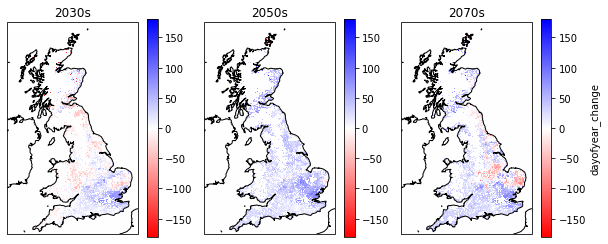

In [99]:
plot_decadal_changes(maxdoys_decadal_changes_test)

#### KTMP and KMAX indexes

- Calculate the proportion of days in each gtime that is KMAX or KTMP.
- Average these proportions over all gtimes.

This gives us a proportion for each day of the dataset. We can then 
- Calculate the monthly average for all the months
- Calculate the monthly climatology for each decade
- Calculate the decadal differences 

Testing with a dataset of scores which is the same in terms of dimensions

In [134]:
ktmpap = file1

In [ ]:
ktmpap_monavg = ktmpap.resample(time="1MS").mean(dim="time")

ktmpap_monavg_climo1 = (
    ktmpap_monavg[:120, :, :]
    .groupby("time.month")
    .mean()
    .expand_dims({"decade": [2020]})
)
ktmpap_monavg_climo2 = (
    ktmpap_monavg[120:240, :, :]
    .groupby("time.month")
    .mean()
    .expand_dims({"decade": [2030]})
)
ktmpap_monavg_climo3 = (
    ktmpap_monavg[240:360, :, :]
    .groupby("time.month")
    .mean()
    .expand_dims({"decade": [2040]})
)
ktmpap_monavg_climo4 = (
    ktmpap_monavg[360:480, :, :]
    .groupby("time.month")
    .mean()
    .expand_dims({"decade": [2050]})
)
ktmpap_monavg_climo5 = (
    ktmpap_monavg[480:600, :, :]
    .groupby("time.month")
    .mean()
    .expand_dims({"decade": [2060]})
)
ktmpap_monavg_climo6 = (
    ktmpap_monavg[600:, :, :]
    .groupby("time.month")
    .mean()
    .expand_dims({"decade": [2070]})
)

ktmpap_monavg_climos = xr.concat(
    [
        ktmpap_monavg_climo1,
        ktmpap_monavg_climo2,
        ktmpap_monavg_climo3,
        ktmpap_monavg_climo4,
        ktmpap_monavg_climo5,
        ktmpap_monavg_climo6,
    ],
    dim="decade",
)

ktmpap_monavg_climo_diffs = ktmpap_monavg_climos.copy()[1:]
for dec in range(1, 6):
    ktmpap_monavg_climo_diffs[dec - 1] = (
        ktmpap_monavg_climos[dec] - ktmpap_monavg_climos[0]
    )

In [171]:
np.iinfo("uint8")

iinfo(min=0, max=255, dtype=uint8)

In [ ]:
((np.uint8(9) + np.uint8(6)) // 2).dtype

### Compare against CROME maps

i.e. current crop distribution

In [3]:
crome = gpd.read_file("CROME_Crops/CROME_Master.shp")
crome.columns

In [103]:
crops = {
    "barley": ["AC01", "AC63"],
    "lettuce": ["AC15"],
    "linseed": ["AC16"],
    "maize": ["AC17"],
    "oats": ["AC19", "AC65"],
    "onion": ["AC20"],
    "wheat": ["AC32", "AC66"],
    "cabbage": ["AC34"],
    "potato": ["AC44"],
    "rye": ["AC68"],
    "peas": ["LG07"],
}

Converted shpfile to grds for each 'AC' code using gdal on the command line, which I can now convert to netcdf and plot using xarray which is more easily customisable

Processing barley
Processing lettuce
Processing linseed
Processing maize
Processing oats
Processing onion
Processing wheat
Processing cabbage
Processing potato
Processing rye
Processing peas


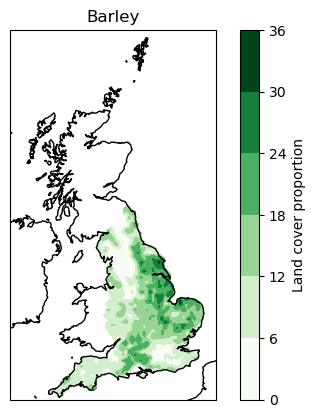

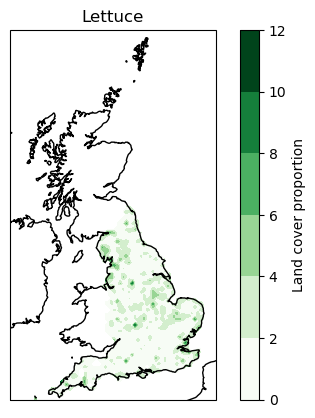

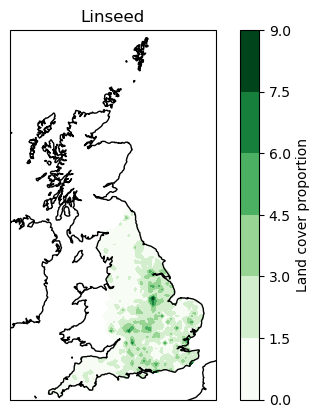

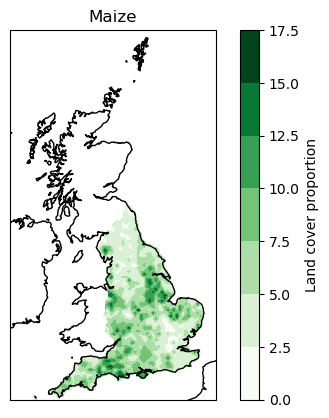

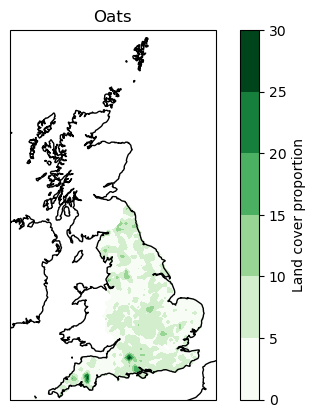

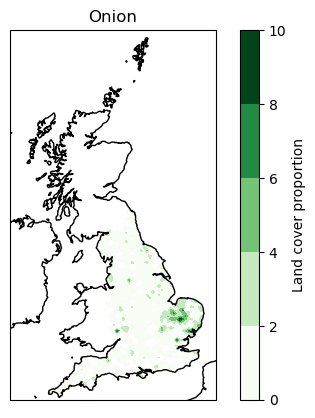

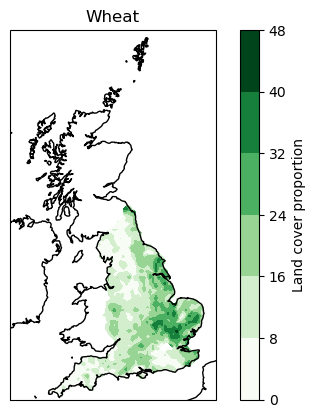

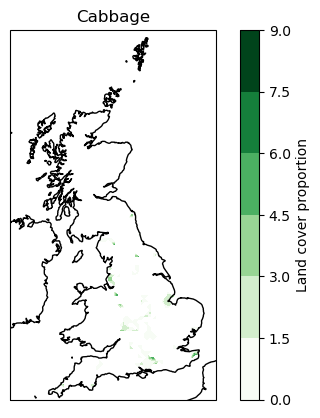

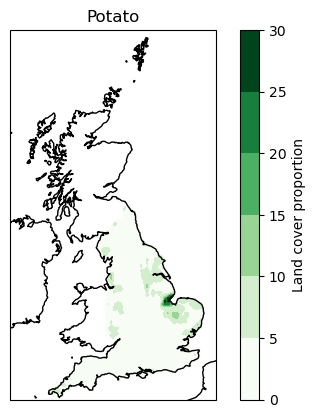

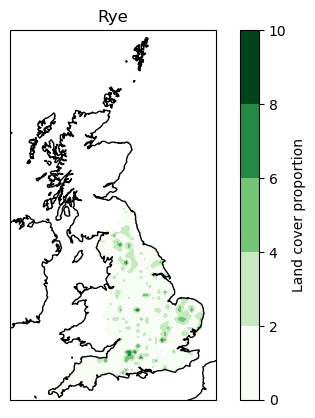

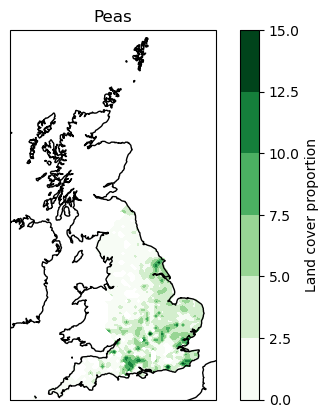

In [104]:
for c in crops.keys():
    print("Processing " + c)
    if len(crops[c]) == 1:
        crop = xr.open_dataarray(
            "CROME_Crops/grds/" + c.capitalize() + "_" + crops[c][0] + ".nc"
        )
    elif len(crops[c]) == 2:
        crop1 = xr.open_dataarray(
            "CROME_Crops/grds/" + c.capitalize() + "_" + crops[c][0] + ".nc"
        )
        crop2 = xr.open_dataarray(
            "CROME_Crops/grds/" + c.capitalize() + "_" + crops[c][1] + ".nc"
        )
        crop = crop1 + crop2
    aggcrop = crop.coarsen(x=10, y=10).mean()

    fig, ax1 = plt.subplots(1, 1, subplot_kw={"projection": cp.crs.OSGB()})
    ax1.coastlines(resolution="10m")
    p = aggcrop.plot.contourf(ax=ax1, cmap="Greens")
    cbarax1 = fig.axes[1]
    cbarax1.set_ylabel("Land cover proportion")
    ax1.set_title(c.capitalize())
    plt.savefig("CROME_plots/" + c + ".png", dpi=600)

### New soil masking

In [18]:
soilds = xr.open_rasterio("EU_STM_soildata/SoilTexture_UK_BGSESDB.tif").squeeze()

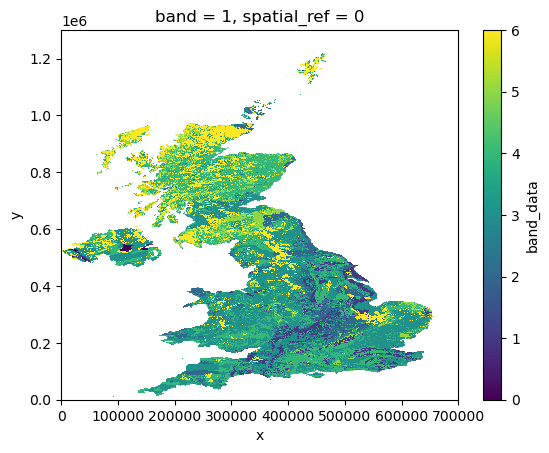

In [62]:
soilds["band_data"].plot()

In [20]:
ycoords = np.arange(500, 1300000, 1000)

In [23]:
soilds = soilds[::-1, :].assign_coords({"y": ycoords})

In [24]:
soil_heavy = xr.where((soilds == 1) | (soilds == 2), 1, 0)
soil_med = xr.where((soilds == 2) | (soilds == 3) | (soilds == 4), 1, 0)
soil_light = xr.where((soilds == 4) | (soilds == 5), 1, 0)

soil_heavy_med = xr.where(
    (soilds == 1) | (soilds == 2) | (soilds == 3) | (soilds == 4), 1, 0
)
soil_heavy_light = xr.where(
    (soilds == 1) | (soilds == 2) | (soilds == 4) | (soilds == 5), 1, 0
)
soil_med_light = xr.where(
    (soilds == 2) | (soilds == 3) | (soilds == 4) | (soilds == 5), 1, 0
)
soil_all = xr.where(
    (soilds == 1) | (soilds == 2) | (soilds == 3) | (soilds == 4) | (soilds == 5), 1, 0
)

In [25]:
soil_heavy_med.to_netcdf("EU_STM_soildata/heavy_med_soil_mask.nc")
soil_heavy_light.to_netcdf("EU_STM_soildata/heavy_light_soil_mask.nc")
soil_med_light.to_netcdf("EU_STM_soildata/med_light_soil_mask.nc")
soil_all.to_netcdf("EU_STM_soildata/all_soil_mask.nc")

In [ ]:
soil_heavy.to_netcdf("EU_STM_soildata/heavy.nc")
soil_med.to_netcdf("EU_STM_soildata/med.nc")
soil_light.to_netcdf("EU_STM_soildata/light.nc")

### Convert 'annuals' scores to new soil masking

In [18]:
with open("crops_to_run_inds.txt", "r") as cropindsfile:
    cropinds = cropindsfile.readlines()
cropinds = [int(cropind[:-1]) for cropind in cropinds]

In [19]:
cropind = 402  # cropinds[0]

ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv"
indir = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores_all/perennial_scoring/scores_rcp26_ens01_a2020"
outdir = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/scores_all/perennial_scoring/new_masking_test"
lcmloc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/Mask_arable_LCM2015_UK.tif"
bgsloc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EU_STM_soildata"
yearaggmethod = "percentile"

if not os.path.exists(outdir):
    os.makedirs(outdir)

ecocropall = pd.read_csv(ecocroploc, engine="python")
ecocrop = ecocropall.drop(["level_0"], axis=1)
testcrop = ecocrop.iloc[
    cropind, :
]  # 19 onions, #117 wheat, #147 chickpea, #66 sweet potato
SOIL = testcrop["TEXT"]
COMNAME = testcrop["COMNAME"]
COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
if "(" in COMNAME:
    COMNAME = "".join(COMNAME.split("("))
    COMNAME = "".join(COMNAME.split(")"))
if "'" in COMNAME:
    COMNAME = "".join(COMNAME.split("'"))
cropname = COMNAME
print(cropname)

filepathtemp = os.path.join(indir, cropname + "_temp.nc")
filepathprec = os.path.join(indir, cropname + "_prec.nc")
tempscore = xr.load_dataarray(filepathtemp)
precscore = xr.load_dataarray(filepathprec)

(
    allscore_decades,
    tempscore_decades,
    precscore_decades,
    allscore_decadal_changes,
    tempscore_decadal_changes,
    precscore_decadal_changes,
) = calc_decadal_changes(
    tempscore, precscore, str(SOIL), lcmloc, bgsloc, cropname, outdir, yearaggmethod
)

true_lavender


### Combine annual/perennial into one dataset

In [41]:
ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim_ann_peren_filter_JR.csv"
ecocropall = pd.read_csv(ecocroploc, engine="python")

Possible LISPA column values are:
- annual
- perennial
- biennial
- annual,perennial
- annual,biennial
- biennial,perennial
- annual,biennial,perennial

Annual

In [57]:
names = ecocropall[ecocropall["LISPA"] == "annual"]["COMNAME"]

a_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            a_names.append(COMNAME)

Perennial

In [ ]:
names = ecocropall[ecocropall["LISPA"] == "perennial"]["COMNAME"]

p_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            p_names.append(COMNAME)

Biennial --> Anuual

In [58]:
names = ecocropall[ecocropall["LISPA"] == "biennial"]["COMNAME"]

b_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            b_names.append(COMNAME)

a_names.extend(b_names)

annual,perennial --> annual

In [63]:
names = ecocropall[ecocropall["LISPA"] == "annual, perennial"]["COMNAME"]

ap_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            ap_names.append(COMNAME)

a_names.extend(ap_names)

annual, biennial --> annual

In [64]:
names = ecocropall[ecocropall["LISPA"] == "annual, biennial"]["COMNAME"]

ab_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            ab_names.append(COMNAME)

a_names.extend(ab_names)

biennial,perennial --> anuual

In [65]:
names = ecocropall[ecocropall["LISPA"] == "biennial, perennial"]["COMNAME"]

bp_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            bp_names.append(COMNAME)

a_names.extend(bp_names)

annual,biennial,perennial --> annual

In [66]:
names = ecocropall[ecocropall["LISPA"] == "annual, biennial, perennial"]["COMNAME"]

abp_names = []
for COMNAME in names:
    if type(COMNAME) == str:
        COMNAME = "_".join(COMNAME.split(",")[0].split(" "))
        if "(" in COMNAME:
            COMNAME = "".join(COMNAME.split("("))
            COMNAME = "".join(COMNAME.split(")"))
        if "'" in COMNAME:
            COMNAME = "".join(COMNAME.split("'"))
        if COMNAME != "nan":
            abp_names.append(COMNAME)

a_names.extend(abp_names)

In [71]:
with open("annual_crops.txt", "w") as afile:
    for name in a_names:
        afile.write(name + "\n")

In [ ]:
with open("perennial_crops.txt", "w") as pfile:
    for name in p_names:
        pfile.write(name + "\n")

### Simple method graphs

toptdays graph

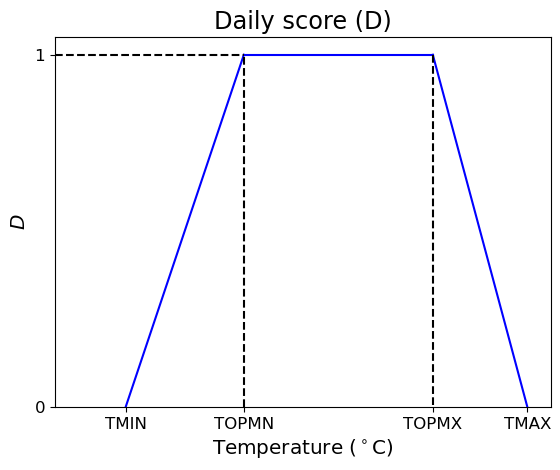

In [95]:
line1x = [10, 15]
line1y = [0, 1]
line2x = [15, 23]
line2y = [1, 1]
line3x = [23, 27]
line3y = [1, 0]

line4x = [15, 15]
line4y = [0, 1]
line5x = [23, 23]
line5y = [1, 0]
line6x = [7, 15]
line6y = [1, 1]

plt.plot(line1x, line1y, color="b")
plt.plot(line2x, line2y, color="b")
plt.plot(line3x, line3y, color="b")
plt.plot(line4x, line4y, color="k", linestyle="--")
plt.plot(line5x, line5y, color="k", linestyle="--")
plt.plot(line6x, line6y, color="k", linestyle="--")

ax = plt.gca()
ax.set_xlim([7, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xticks([10, 15, 23, 27])
ax.set_xticklabels(labels=["TMIN", "TOPMN", "TOPMX", "TMAX"], fontsize="large")
ax.set_yticks([0, 1])
ax.set_yticklabels(labels=["0", "1"], fontsize="large")
ax.set_xlabel("Temperature (" + r"$^\circ $C" + ")", size="x-large")
ax.set_ylabel(r"$D$", size="x-large")
ax.set_title("Daily score (D)", size="xx-large")
plt.savefig("plots/method_graph_D.png", dpi=600)

Annuals method graph

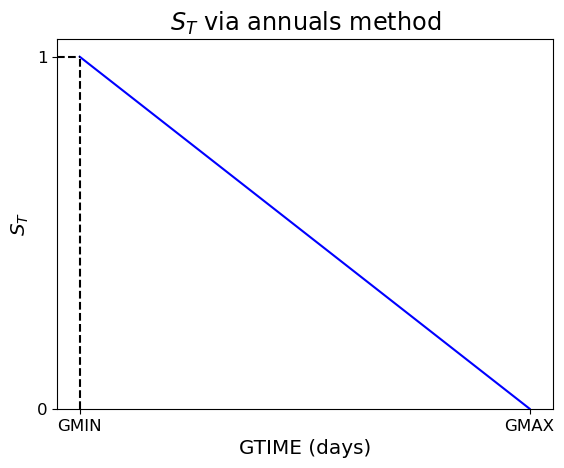

In [98]:
line1x = [100, 300]
line1y = [100, 0]
line2x = [100, 100]
line2y = [0, 100]
line3x = [90, 100]
line3y = [100, 100]

plt.plot(line1x, line1y, color="b")
plt.plot(line2x, line2y, color="k", linestyle="--")
plt.plot(line3x, line3y, color="k", linestyle="--")

ax = plt.gca()
ax.set_xlim([90, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xticks([100, 300])
ax.set_xticklabels(labels=["GMIN", "GMAX"], fontsize="large")
ax.set_yticks([0, 100])
ax.set_yticklabels(labels=["0", "1"], fontsize="large")
ax.set_xlabel("GTIME (days)", size="x-large")
ax.set_ylabel(r"$S_T$", size="x-large")
ax.set_title(r"$S_T$" + " via annuals method", size="xx-large")
plt.savefig("plots/method_graph_S_T_annual.png", dpi=600)

### Add cropind to ann/peren lists

Read in ann and peren lists

In [99]:
with open("annual_crops.txt") as anlistfile:
    alist = anlistfile.readlines()
with open("perennial_crops.txt") as plistfile:
    plist = plistfile.readlines()

alist = [crop[:-1] for crop in alist]
plist = [crop[:-1] for crop in plist]

Remove any we don't actual model by finding the intersect of these lists and the crop dimension of our results files

In [110]:
# load results
allannualsdata = xr.load_dataset(
    "scores_all/annual_scoring/allcrop_years_rcp85_ensmean_combinedscore.nc"
)
allperdata = xr.load_dataset(
    "scores_all/perennial_scoring/allcrop_years_rcp85_ensmean_combinedscore.nc"
)

# load the crops we MODELLED as annual and perennial (should be more or less the same)
allannualscrops = allannualsdata.crop.values
allpercrops = allperdata.crop.values

# find the overlap between the full lists and those we've modelled
alist2 = np.intersect1d(alist, allannualscrops)
plist2 = np.intersect1d(plist, allpercrops)

Read in the EcoCrop DB and loop through the rows, obtaining the cropind (row index) and the common name

In [115]:
ecocroploc = "/gws/nopw/j04/ceh_generic/matbro/ecocrop/EcoCrop_DB_secondtrim.csv"
ecocropall = pd.read_csv(ecocroploc, engine="python")
ecocrop = ecocropall.drop(["level_0"], axis=1)
COMNAME = ecocrop["COMNAME"]

In [118]:
newalist = []
newplist = []
idx = 0
for c in COMNAME:
    if type(c) == str:
        comname = "_".join(c.split(",")[0].split(" "))
        if "(" in comname:
            comname = "".join(comname.split("("))
            comname = "".join(comname.split(")"))
        if "'" in comname:
            comname = "".join(comname.split("'"))

        if comname in alist2:
            print(comname + " is annual")
            newalist.append(str(idx) + "," + comname)
        elif comname in plist2:
            print(comname + " is perennial")
            newplist.append(str(idx) + "," + comname)
        else:
            print(comname + " not in alist or plist (i.e. not modelled by us)")

    idx += 1

abelmoskus is annual
Ellington_curse not in alist or plist (i.e. not modelled by us)
New_Zealand_kauri not in alist or plist (i.e. not modelled by us)
wild_leek is annual
onion is annual
branching_onion is annual
garlic is annual
whitespot is annual
wild_celery is annual
celery is annual
asparagus is perennial
oat is annual
common_bamboo not in alist or plist (i.e. not modelled by us)
Silver_beet is annual
blue_grass not in alist or plist (i.e. not modelled by us)
bread_grass not in alist or plist (i.e. not modelled by us)
kurrajong not in alist or plist (i.e. not modelled by us)
Chinese_cabbage is annual
Indian_mustard is annual
Onions_bulb is annual
cauliflower is annual
cabbage is annual
Brussels_sprouts is annual
broccoli is annual
Chinese_chives is annual
tea is perennial
jack_bean is annual
sweet_pepper is annual
cayenne_pepper is perennial
periwinkle not in alist or plist (i.e. not modelled by us)
African_foxtail not in alist or plist (i.e. not modelled by us)
endive is annual
c

In [122]:
with open("annual_crops_with_index.txt", "w") as afile:
    for name in newalist:
        afile.write(name + "\n")
with open("perennial_crops_with_index.txt", "w") as pfile:
    for name in newplist:
        pfile.write(name + "\n")

For each row, check if the common name is in the annual or perennial crop list

Add the common name and cropind to a new annual or perennial list as determined in previous step

Write new lists to disk

### Create copy of EcoCrop DB just containing the crops and params that we used in the model

In [3]:
ecdb = pd.read_csv("EcoCrop_DB_secondtrim_JWR.csv")

Drop crops (rows) that have 'NaN' in the Pandas_index column. We didn't model these crops

In [13]:
ecdb_subset = ecdb.dropna(subset="Pandas_index")

Can then drop this column as is identical to index

In [28]:
ecdb_subset = ecdb_subset.drop("Pandas_index", axis=1)

Set annual and perennial method crops

In [29]:
anncropinds = list(np.loadtxt("annual_crops_with_index.txt", usecols=0, delimiter=","))
anncropinds = [int(ind) for ind in anncropinds]

In [35]:
pencropinds = np.loadtxt("perennial_crops_with_index.txt", usecols=0, delimiter=",")
pencropinds = [int(ind) for ind in pencropinds]

In [54]:
ecdb_subset.loc[anncropinds, "LISPA"] = "annual"
ecdb_subset.loc[pencropinds, "LISPA"] = "perennial"

In [58]:
ecdb_subset.to_csv("EcoCrop_DB_modelled_crops.csv")

### Check disk read speeds

In [59]:
year = 2021
prepath1 = (
    "/work/scratch-pw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_"
    + str(year)
    + ".nc"
)
prepath2 = (
    "/home/users/mattjbr/ecocrop/metdata/UKCP18_BC_01/pr/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_"
    + str(year)
    + ".nc"
)
prepath3 = (
    "/work/scratch-nopw/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_"
    + str(year)
    + ".nc"
)
prepath4 = (
    "/work/scratch-pw2/mattjbr/ecocrop/metdata/ukcp18_rcp85_land-rcm_uk_1km_01_v20190731_pr_bias_corrected_"
    + str(year)
    + ".nc"
)
prevname = "pr"

In [60]:
%%time
pre1 = xr.open_dataset(prepath1)[prevname]
presum1 = pre1.sum()
print(presum1)

<xarray.DataArray 'pr' ()>
array(3242.9622, dtype=float32)
CPU times: user 4.66 s, sys: 1.72 s, total: 6.38 s
Wall time: 10.5 s


In [61]:
%%time
pre2 = xr.open_dataset(prepath2)[prevname]
presum2 = pre2.sum()
print(presum2)

<xarray.DataArray 'pr' ()>
array(3242.9622, dtype=float32)
CPU times: user 4.68 s, sys: 897 ms, total: 5.57 s
Wall time: 26.8 s


In [62]:
%%time
pre3 = xr.open_dataset(prepath3)[prevname]
presum3 = pre3.sum()
print(presum3)

<xarray.DataArray 'pr' ()>
array(3242.9622, dtype=float32)
CPU times: user 4.52 s, sys: 868 ms, total: 5.39 s
Wall time: 6.76 s


In [ ]:
%%time
pre4 = xr.open_dataset(prepath4)[prevname]
presum4 = pre4.sum()
print(presum4)